# Define the problem

Mean-variance portfolio optimization problem for $n$ assets:

$$\begin{aligned}
\min_{x \in \{0, 1\}^n}  q x^T \Sigma x - \mu^T x\\
\text{subject to: } 1^T x = B
\end{aligned}$$

where we use the following notation:

- $x \in \{0, 1\}^n$ denotes the vector of binary decision variables, which indicate which assets to pick ($x[i] = 1$) and which not to pick ($x[i] = 0$),
- $\mu \in \mathbb{R}^n$ defines the expected returns for the assets,
- $\Sigma \in \mathbb{R}^{n \times n}$ specifies the covariances between the assets,
- $q > 0$ controls the risk appetite of the decision maker,
- and $B$ denotes the budget, i.e. the number of assets to be selected out of $n$.

We assume the following simplifications:
- all assets have the same price (normalized to 1),
- the full budget $B$ has to be spent, i.e. one has to select exactly $B$ assets.

In [1]:
from qiskit.circuit.library import EfficientSU2, TwoLocal
from qiskit.result import QuasiDistribution
from qiskit_aer.primitives import Sampler
from qiskit_algorithms import NumPyMinimumEigensolver, QAOA, SamplingVQE
from qiskit_algorithms.optimizers import COBYLA, SLSQP, CRS
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import RandomDataProvider, YahooDataProvider
from qiskit_finance import QiskitFinanceError
from qiskit_optimization.algorithms import (
    MinimumEigenOptimizer,
    RecursiveMinimumEigenOptimizer,
    SolutionSample,
    OptimizationResultStatus,
)
from qiskit.visualization import plot_histogram
from typing import List, Tuple
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime

num_assets = 10 # set number of assets (= number of qubits)

# From data to quadratic program

In [2]:
def pseudorandom_to_qp(num_assets=5, risk_factor=0.5, budget=2,
                       start=datetime.datetime(2016, 1, 1), end=datetime.datetime(2016, 1, 30),
                       seed=123, **kwargs):

    # Generate expected return and covariance matrix from (random) time-series
    stocks = [("STOCK %s" % i) for i in range(num_assets)]
    data = RandomDataProvider(
        tickers=stocks,
        start=start,
        end=end,
        seed=seed,
        **kwargs
    )
    data.run()

    # Set up quadratic problem
    mu = data.get_period_return_mean_vector()
    sigma = data.get_period_return_covariance_matrix()
    q = risk_factor  # set risk factor

    portfolio = PortfolioOptimization(
        expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget
    )
    qp = portfolio.to_quadratic_program()

    return qp, data

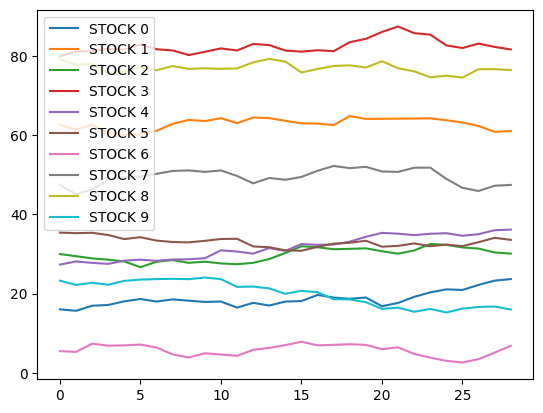

Problem name: Portfolio optimization

Minimize
  0.001270694296030004*x_0^2 + 7.34022166934733e-05*x_0*x_1
  + 0.00012860053085450988*x_0*x_2 - 9.986121318021848e-05*x_0*x_3
  - 0.00031319920324307385*x_0*x_4 + 0.00023939105610393827*x_0*x_5
  + 0.002580077634496565*x_0*x_6 + 0.0002822707285926113*x_0*x_7
  - 2.4627728780339536e-05*x_0*x_8 + 0.0008773295028570904*x_0*x_9
  + 0.00012924335651113268*x_1^2 + 5.304275948260219e-05*x_1*x_2
  + 4.4481620835391664e-05*x_1*x_3 - 1.324515734671949e-05*x_1*x_4
  - 7.994799341375344e-05*x_1*x_5 - 0.0002586708531637839*x_1*x_6
  - 1.727664161998716e-05*x_1*x_7 + 7.300289385160073e-05*x_1*x_8
  + 0.0001276924410830368*x_1*x_9 + 0.0003957523406615203*x_2^2
  - 0.00012388738164026145*x_2*x_3 - 9.702733849709298e-07*x_2*x_4
  - 0.00019632487464354438*x_2*x_5 - 0.0007537519512595539*x_2*x_6
  + 7.88669970147002e-05*x_2*x_7 - 0.0001420827541434582*x_2*x_8
  + 7.114657521911855e-05*x_2*x_9 + 9.89462926895246e-05*x_3^2
  + 8.515335218299407e-05*x_3*x_4 - 

In [3]:
qp, data = pseudorandom_to_qp(num_assets=num_assets)

# Visualize the data
for cnt, s in enumerate(data._tickers):
    plt.plot(data._data[cnt], label=s)
plt.legend()
plt.show()

# Print the quadratic program
print(qp.prettyprint())

# VQE: ideal simulation

Tools: SamplingVQE with MinimumEigenOptimizer

In [27]:
def print_result(result, qp):
    """
    Print final and intermediate results
    """

    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    probabilities = (
        eigenstate.binary_probabilities()
        if isinstance(eigenstate, QuasiDistribution)
        else {k: np.abs(v) ** 2 for k, v in eigenstate.to_dict().items()}
    )
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    probabilities = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)

    for k, v in probabilities:
        x = np.array([int(i) for i in list(reversed(k))])
        value = qp.objective.evaluate(x)
        print("%10s\t%.4f\t\t%.4f" % (x, value, v))


def get_result_numpy(qp, penalty=None):
    """
    Get the result using the exact, classical eigensolver NumPyMinimumEigensolver.
    Return: MinimumEigenOptimizationResult
    """

    exact_mes = NumPyMinimumEigensolver()
    exact_eigensolver = MinimumEigenOptimizer(exact_mes, penalty=penalty)
    result = exact_eigensolver.solve(qp)

    return result

# Configure a fully parameterized TwoLocal ansatz

def get_result_SamplingVQE(
        qp,
        ansatz = TwoLocal(num_qubits=num_assets,rotation_blocks=['rx', 'y'], entanglement='linear', reps=2),
        optimizer=COBYLA(),
        sampler=Sampler(),
        penalty=None
):
    """
    Get the result using as model SamplingVQE(sampler, ansatz, optimizer).
    Return: MinimumEigenOptimizationResult
    """

    # List to store the cost history
    cost_history_dict = {
        "params": [],
        "cost": [],
        "meta": []
    }

    # Define the callback function to capture the cost value at each iteration
    def store_cost(eval_count, params, value, meta):
        cost_history_dict["params"].append(params)
        cost_history_dict["cost"].append(value.real)
        cost_history_dict["meta"].append(meta)

    svqe_mes = SamplingVQE(ansatz=ansatz, optimizer=optimizer,
                           sampler=sampler, callback=store_cost)
    svqe = MinimumEigenOptimizer(svqe_mes, penalty=penalty)
    result = svqe.solve(qp)

    return result, cost_history_dict


def get_result_QAOA(
    qp,
    optimizer=COBYLA(),
    reps = 1
):
    
    cost_history_dict = {
        "params": [],
        "cost": [],
        "meta": []
    }

    # Define the callback function to capture the cost value at each iteration
    def store_cost(eval_count, params, value, meta):
        cost_history_dict["params"].append(params)
        cost_history_dict["cost"].append(value.real)
        cost_history_dict["meta"].append(meta)


    qaoa_mes = QAOA(sampler = Sampler(), optimizer=optimizer, reps=reps, callback= store_cost)
    qaoa = MinimumEigenOptimizer(qaoa_mes)
    result = qaoa.solve(qp)

    return result, cost_history_dict


def get_result_wrapper(result_function, **kwargs):
    """
    Wrapper function to call either get_result_QAOA or get_result_SamplingVQE
    with the provided keyword arguments.
    
    Parameters:
    - result_function: The function to call (get_result_QAOA or get_result_SamplingVQE)
    - kwargs: The keyword arguments to pass to the function
    
    Returns:
    - result: The result from the called function
    - cost_history_dict: The cost history dictionary from the called function
    """

    result, cost_history_dict = result_function(**kwargs)
    
    return result, cost_history_dict


def plot_result_histogram(result, threshold=0):
    """
    Plot the histogram of the valid samples.
    """
    
    # Filter the samples with OptimizationResultStatus.SUCCESS and value below threshold
    valid_samples = []
    for s in result.samples:
        if s.status == OptimizationResultStatus.SUCCESS and s.probability > threshold:
            valid_samples.append(s)

    # Create samples dictionary
    samples_for_plot = {
        " ".join(f"{int(v)}" for i, v in enumerate(s.x)): s.probability
        for s in valid_samples
    }

    # Plot histogram
    fig = plot_histogram(samples_for_plot)
    return fig


def plot_cost_history(cost_history_dict, reference=None):
    """
    Plot the cost history.
    """

    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.plot(cost_history_dict["cost"], lw=2, marker="o")
    if reference is not None:
        ax.axhline(reference, color="red", ls="--")
    ax.set_ylabel("Cost", fontsize=14)
    ax.set_xlabel("Evaluation count", fontsize=14)
    ax.set_title("Cost history", fontsize=14)
    
    return fig

def prob_exact(result_svqe, result_exact):
    """"
    Find the probability of the exact optimal solution in the SamplingVQE result.
    """
    exact_x = result_exact.x
    prob_vqe = 0
    for sample in result_svqe.samples:
        if sample.x.all() == exact_x.all():
            prob_vqe = sample.probability
            break

    return prob_vqe

In [88]:
# Data
qp, data = pseudorandom_to_qp()

# Exact result via classical eigensolver
result_exact = get_result_numpy(qp)

# SamplingVQE result
result_svqe, history = get_result_SamplingVQE(qp)

plot_cost_history(history, reference=result_exact.min_eigen_solver_result.eigenvalue.real)

print_result(result_svqe, qp)
print_result(result_exact, qp)

plot_result_histogram(result_svqe)

ImportError: cannot import name 'QuantumInstance' from 'qiskit.utils' (d:\Qiskit hackathon\.venv\Lib\site-packages\qiskit\utils\__init__.py)

## Sweep the number of layers

Optimal: 1 layer

Starting entanglement  full ,  1  layers
Starting entanglement  full ,  2  layers
Starting entanglement  full ,  3  layers
Starting entanglement  full ,  4  layers
Starting entanglement  full ,  5  layers
Starting entanglement  full ,  6  layers
Starting entanglement  full ,  7  layers
Starting entanglement  full ,  15  layers


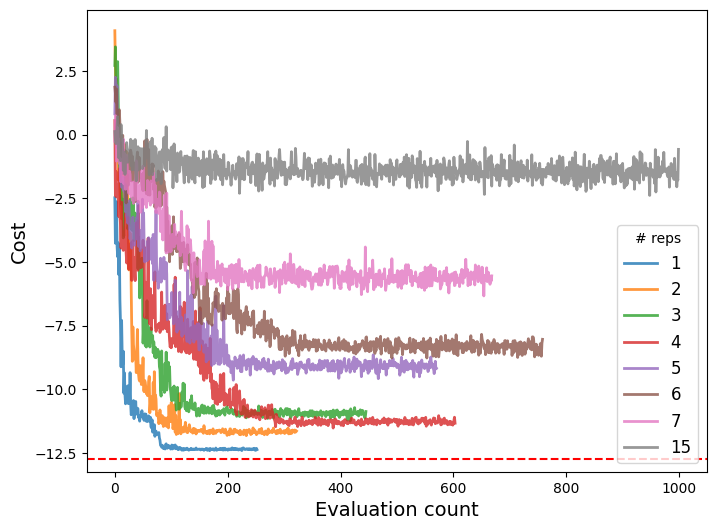

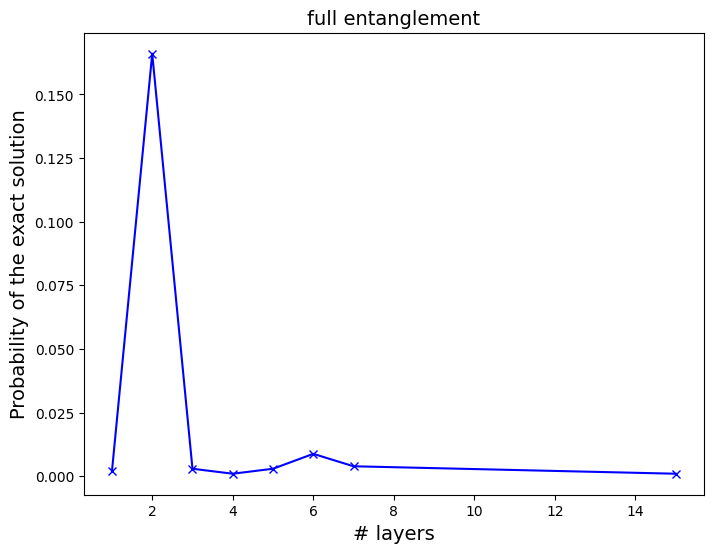

In [9]:
# Sweep number of layers
num_assets = 10
reps_sweep = [1, 2, 3, 4, 5, 6, 7, 15]
save_folder = r"D:/Qiskit hackathon/plots_TwoLocal/num_reps_sweep_10_full/"

# Parameters
rotation_blocks=["rx", "y"]
entanglement_blocks="ecr"
entanglement="full"

# Data
qp, data = pseudorandom_to_qp(num_assets=num_assets)

# Exact result via classical eigensolver
result_exact = get_result_numpy(qp)
reference_cost = result_exact.min_eigen_solver_result.eigenvalue.real
reference_fval = result_exact.fval

# Make figure for cost plot
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# Sweep
prob_vqe_exact = []
error_vqe_cost = []

for reps in reps_sweep:

    print('Starting entanglement ', entanglement, ', ', reps, ' layers')

    ansatz = TwoLocal(num_qubits=num_assets,rotation_blocks=rotation_blocks, entanglement=entanglement, reps=reps, entanglement_blocks=entanglement_blocks)
    # ansatz = EfficientSU2(num_qubits=num_assets, su2_gates=su2_gates, entanglement=entanglement, reps=reps)
    result_svqe, history = get_result_SamplingVQE(qp, ansatz=ansatz)

    # Function values and probabilities
    fvals = np.array([s.fval for s in result_svqe.samples])
    probabilities = np.array([s.probability for s in result_svqe.samples])

    # Compute statistics of the results
    prob_vqe_exact.append(prob_exact(result_svqe, result_exact))
    error_vqe_cost.append(result_svqe.min_eigen_solver_result.eigenvalue.real - reference_cost)

    ax.plot(history["cost"], lw=2, alpha=0.8, label=f"{reps}")

# Complete the cost plot
ax.axhline(reference_cost, color="red", ls="--")
ax.set_ylabel("Cost", fontsize=14)
ax.set_xlabel("Evaluation count", fontsize=14)
ax.legend(title="# reps", fontsize=12)
fig.savefig(save_folder + f"cost_history.png")
plt.show()

# Plot the probability of the exact solution as a function of the error in the cost function value (compared to the exact solution)
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(reps_sweep, prob_vqe_exact, marker="x", color="blue")
ax.set_ylabel("Probability of the exact solution", fontsize=14)
ax.set_xlabel("# layers", fontsize=14)
ax.set_title(entanglement + r" entanglement", fontsize=14)
fig.savefig(save_folder + entanglement + r"_" + str(reps) + r"rep_prob.png")

## Sweep the number of assets

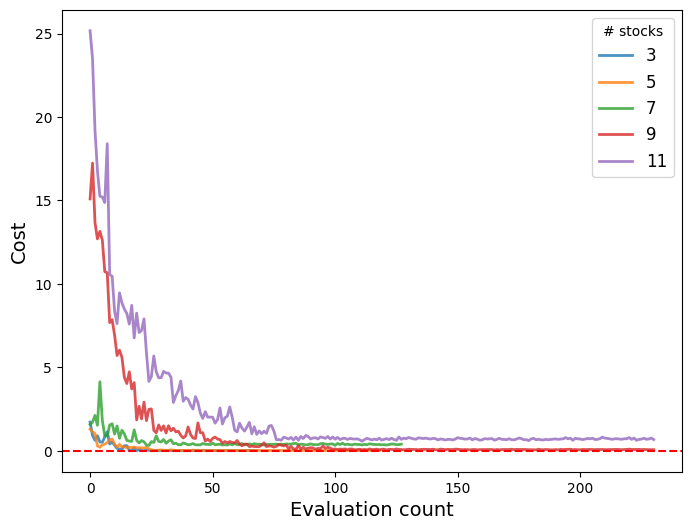

ValueError: x and y must have same first dimension, but have shapes (8,) and (5,)

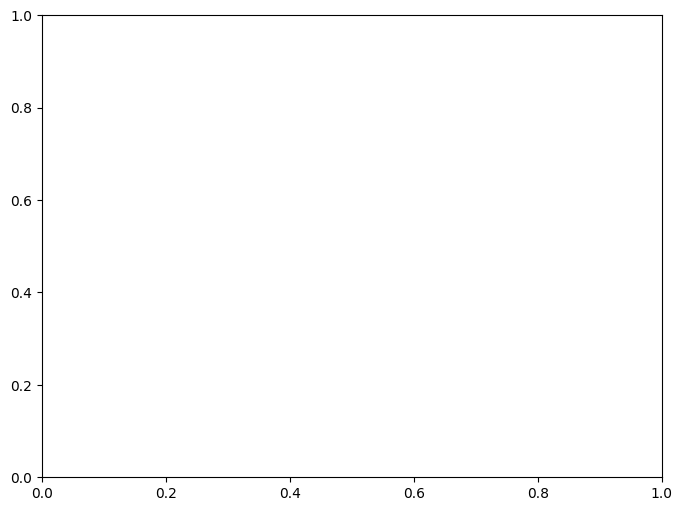

In [11]:
# Sweep number of layers
num_assets_sweep = [3, 5, 7, 9, 11]
save_folder = r"D:/Qiskit hackathon/plots_TwoLocal/num_assets_sweep_1_rep/"

# Parameters
rotation_blocks=["rx", "y"]
entanglement_blocks="ecr"
entanglement="full"
reps = 1

# Make figure for NORMALIZED cost plot: cost - reference
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# Sweep
reference_fval = np.array([])
prob_vqe_exact = []
error_vqe_cost = []
for q in num_assets_sweep:

    print('Starting entanglement ', entanglement, ', ', q, ' assets')

    # Data
    qp, data = pseudorandom_to_qp(num_assets=q)

    # Exact result via classical eigensolver
    result_exact = get_result_numpy(qp)
    reference_cost = result_exact.min_eigen_solver_result.eigenvalue.real
    reference_fval = np.append(reference_fval, result_exact.fval)

    # SamplingVQE result
    # ansatz = EfficientSU2(num_qubits=q, reps=reps, su2_gates=su2_gates, entanglement=entanglement)
    ansatz = TwoLocal(num_qubits=num_assets,rotation_blocks=rotation_blocks, 
                      entanglement=entanglement, reps=reps, entanglement_blocks=entanglement_blocks)
    result_svqe, history = get_result_SamplingVQE(qp, ansatz=ansatz)

    # Function values and probabilities
    fvals = np.array([s.fval for s in result_svqe.samples])
    probabilities = np.array([s.probability for s in result_svqe.samples])

    prob_vqe_exact.append(prob_exact(result_svqe, result_exact))
    error_vqe_cost.append(result_svqe.min_eigen_solver_result.eigenvalue.real - reference_cost)


    ax.plot(history["cost"] - reference_cost, lw=2, alpha=0.8, label=f"{q}")

# Complete the cost plot
ax.axhline(0, color="red", ls="--")
ax.set_ylabel("Cost", fontsize=14)
ax.set_xlabel("Evaluation count", fontsize=14)
ax.legend(title="# stocks", fontsize=12)
fig.savefig(save_folder + f"cost_history.png")
plt.show()

# Plot the probability of the exact solution as a function of the error in the cost function value (compared to the exact solution)
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(num_assets_sweep, prob_vqe_exact, marker="x", color="blue")
ax.set_ylabel("Probability of the exact solution", fontsize=14)
ax.set_xlabel("# layers", fontsize=14)
ax.set_title(entanglement + r" entanglement", fontsize=14)
fig.savefig(save_folder + entanglement + r"_" + str(reps) + r"rep_prob.png")


## Sweep the SU2 gates

Results in D:\Qiskit hackathon\plots\su2_gates_sweep_1rep_final\cost_history.png

Conclusion: use rx gate as single parametrized gate!

su2_gates = ["rx", "y"]

['rx', 'y']
['ry', 'x']
['y', 'rx']
['x', 'ry']
['rx', 'ry']
['ry', 'rx']


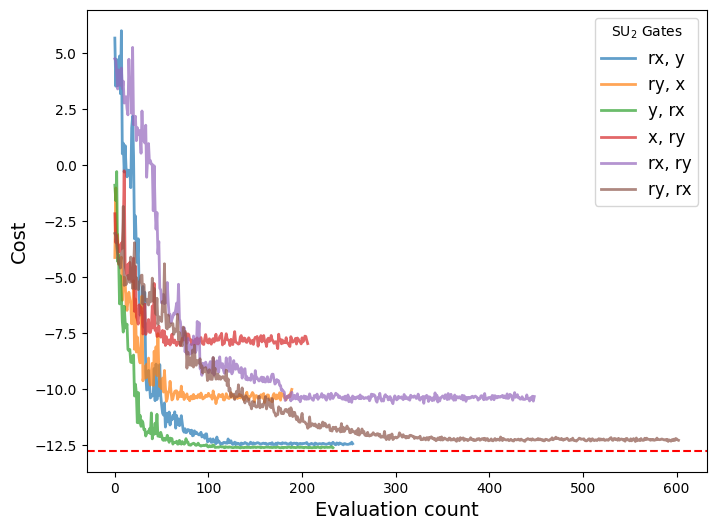

In [14]:
num_assets = 10
save_folder = r"D:/Qiskit hackathon/plots_TwoLocal/su2_gates_sweep_1rep/"

# Parameters
rotation_blocks_sweep=[["rx", "y"], ["ry", "x"], ["y", "rx"], ["x", "ry"], ["rx", "ry"], ["ry", "rx"]]
entanglement="full"
reps = 1
entanglement_blocks="ecr"

# Data
qp, data = pseudorandom_to_qp(num_assets=num_assets)

# Exact result via classical eigensolver
result_exact = get_result_numpy(qp)
reference_cost = result_exact.min_eigen_solver_result.eigenvalue.real
reference_fval = result_exact.fval

# Make figure for cost plot
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.axhline(reference_cost, color="red", ls="--")

# Sweep
for rotation_blocks in rotation_blocks_sweep:

    print(rotation_blocks)

    # ansatz = EfficientSU2(num_qubits=num_assets, su2_gates=su2_gates, entanglement=entanglement, reps=reps)
    ansatz = TwoLocal(num_qubits=num_assets,rotation_blocks=rotation_blocks, entanglement=entanglement, reps=reps,
                      entanglement_blocks=entanglement_blocks)

    result_svqe, history = get_result_SamplingVQE(qp, ansatz=ansatz)

    # Function values and probabilities
    fvals = np.array([s.fval for s in result_svqe.samples])
    probabilities = np.array([s.probability for s in result_svqe.samples])

    # Compute statistics of the results
    ax.plot(history["cost"], lw=2, alpha=0.7, label=rotation_blocks[0] + r", " + rotation_blocks[1])

# Complete the cost plot
ax.set_ylabel("Cost", fontsize=14)
ax.set_xlabel("Evaluation count", fontsize=14)
ax.legend(title="SU$_2$ Gates", fontsize=12)
fig.savefig(save_folder + f"cost_history.png")
plt.show()


## Sweep the entangling types

full
linear
sca
pairwise


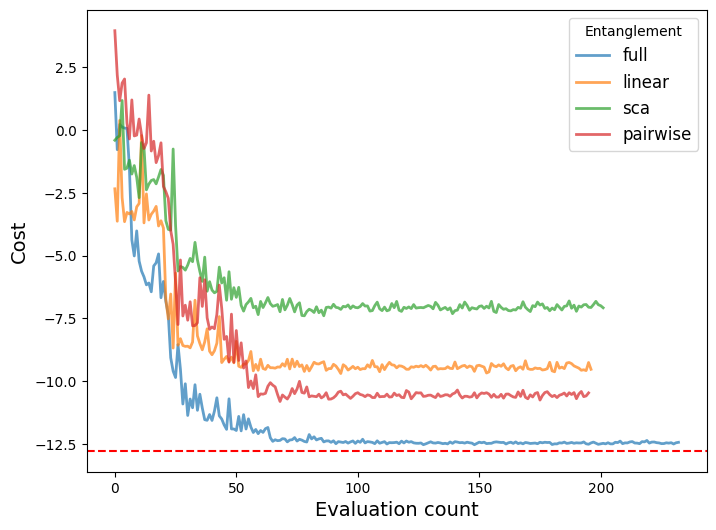

In [15]:
num_assets = 10
save_folder = r"D:/Qiskit hackathon/plots_TwoLocal/ent_gates_sweep_1rep/"

# Parameters
rotation_blocks = ["y", "rx"]
entanglement_sweep = ["full", "linear", "sca", "pairwise"]
entanglement_blocks="ecr"
reps = 1

# Data
qp, data = pseudorandom_to_qp(num_assets=num_assets)

# Exact result via classical eigensolver
result_exact = get_result_numpy(qp)
reference_cost = result_exact.min_eigen_solver_result.eigenvalue.real
reference_fval = result_exact.fval

# Make figure for cost plot
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.axhline(reference_cost, color="red", ls="--")

# Sweep
for entanglement in entanglement_sweep:

    print(entanglement)

    # ansatz = EfficientSU2(num_qubits=num_assets, su2_gates=su2_gates, entanglement=entanglement, reps=reps)
    ansatz = TwoLocal(num_qubits=num_assets,rotation_blocks=rotation_blocks, entanglement=entanglement, reps=reps,
                      entanglement_blocks=entanglement_blocks)

    result_svqe, history = get_result_SamplingVQE(qp, ansatz=ansatz)

    # Function values and probabilities
    fvals = np.array([s.fval for s in result_svqe.samples])
    probabilities = np.array([s.probability for s in result_svqe.samples])

    ax.plot(history["cost"], lw=2, alpha=0.7, label=entanglement)

# Complete the cost plot
ax.set_ylabel("Cost", fontsize=14)
ax.set_xlabel("Evaluation count", fontsize=14)
ax.legend(title="Entanglement", fontsize=12)
fig.savefig(save_folder + f"cost_history.png")
plt.show()


## Sweep the optimization algorithm

COBYLA: local, gradient-free method
SLSQP: local, gradient-based method
CRS: globbal method

ONLY COBYLA WORKS!

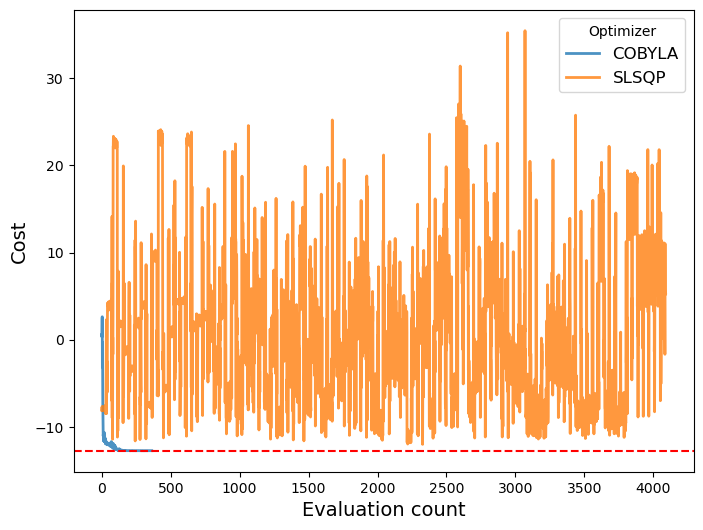

In [ ]:
# Sweep number of layers
optimizer_sweep = ["COBYLA", "SLSQP"]
save_folder = r"/Users/cosmin/Desktop/Hackathon/plots/opt_alg/"

# Parameters
rotation_blocks=["y", "rx"]
entanglement="sca"
num_assets = 10
reps = 2

# Data
qp, data = pseudorandom_to_qp(num_assets=num_assets)

# Exact result via classical eigensolver
result_exact = get_result_numpy(qp)
reference_cost = result_exact.min_eigen_solver_result.eigenvalue.real
reference_fval = result_exact.fval

# Make figure for cost plot
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# Sweep
mean_results = []
best_results = []
std_results = []
for optimizer_name in optimizer_sweep:

    # ansatz = EfficientSU2(num_qubits=num_assets, su2_gates=rotation_blocks, entanglement=entanglement, reps=reps)
    ansatz = TwoLocal(num_qubits=num_assets,rotation_blocks=rotation_blocks, entanglement=entanglement, reps=reps)

    optimizer_class = globals()[optimizer_name]
    optimizer = optimizer_class()
    result_svqe, history = get_result_SamplingVQE(qp, ansatz=ansatz, optimizer=optimizer)

    # Function values and probabilities
    fvals = np.array([s.fval for s in result_svqe.samples])
    probabilities = np.array([s.probability for s in result_svqe.samples])

    # Compute statistics of the results
    mean_results.append(np.sum(fvals * probabilities))
    best_results.append(np.min(fvals))
    std_results.append(np.sqrt(np.sum((fvals - np.sum(fvals * probabilities)) ** 2 * probabilities)))

    # hist = plot_result_histogram(result_svqe)
    # hist.savefig(save_folder + f"histogram_reps_{reps}.png")

    ax.plot(history["cost"], lw=2, alpha=0.8, label=optimizer_name)

# Complete the cost plot
ax.axhline(reference_cost, color="red", ls="--")
ax.set_ylabel("Cost", fontsize=14)
ax.set_xlabel("Evaluation count", fontsize=14)
ax.legend(title="Optimizer", fontsize=12)
fig.savefig(save_folder + f"cost_history.png")
plt.show()

## Mixed sweep: #layers and entanglement

1 ,  full
2 ,  full
1 ,  linear
2 ,  linear
1 ,  sca
2 ,  sca
1 ,  pairwise
2 ,  pairwise


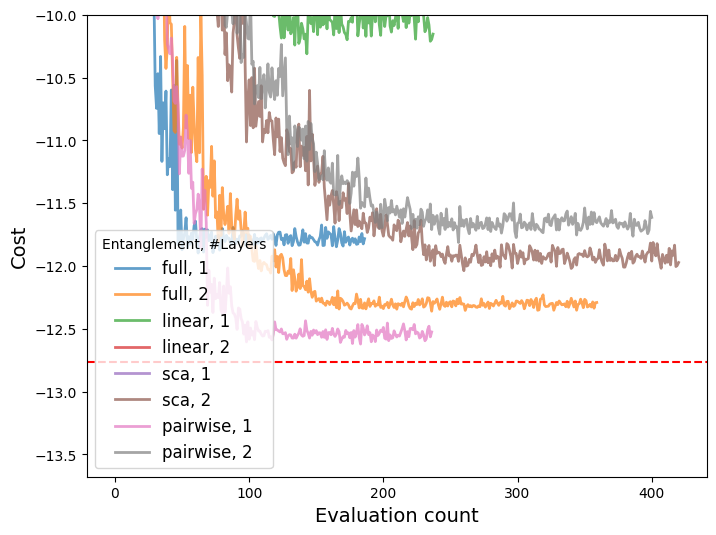

In [18]:
num_assets = 10
save_folder = r"D:/Qiskit hackathon/plots_TwoLocal/ent_AND_reps_sweep_10/"

# Parameters
rotation_blocks = ["y", "rx"]
entanglement_sweep = ["full", "linear", "sca", "pairwise"]
reps_sweep = [1, 2]
entanglement_blocks="ecr"

# Data
qp, data = pseudorandom_to_qp(num_assets=num_assets)

# Exact result via classical eigensolver
result_exact = get_result_numpy(qp)
reference_cost = result_exact.min_eigen_solver_result.eigenvalue.real
reference_fval = result_exact.fval

# Make figure for cost plot
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.axhline(reference_cost, color="red", ls="--")

# Sweep
for entanglement in entanglement_sweep:
    for reps in reps_sweep:

        print(reps, ', ', entanglement)

        # ansatz = EfficientSU2(num_qubits=num_assets, su2_gates=su2_gates, entanglement=entanglement, reps=reps)
        ansatz = TwoLocal(num_qubits=num_assets,rotation_blocks=rotation_blocks, entanglement=entanglement, 
                          reps=reps, entanglement_blocks=entanglement_blocks)

        result_svqe, history = get_result_SamplingVQE(qp, ansatz=ansatz)

        # Function values and probabilities
        fvals = np.array([s.fval for s in result_svqe.samples])
        probabilities = np.array([s.probability for s in result_svqe.samples])

        ax.plot(history["cost"], lw=2, alpha=0.7, label=entanglement + r", " + str(reps))

# Complete the cost plot
ax.set_ylim(top=-10)
ax.set_ylabel("Cost", fontsize=14)
ax.set_xlabel("Evaluation count", fontsize=14)
ax.legend(title="Entanglement, #Layers", fontsize=12)
fig.savefig(save_folder + f"cost_history.png")
plt.show()


## Check variability

How much does the alg. differ each run? the only random part is the parameters initialization and the quantum nature of the algorithm. Here the same algo, with the same parameters, is run multiple times and then plotted.

Starting entanglement  full ,  1  layers, run  0
Starting entanglement  full ,  1  layers, run  1
Starting entanglement  full ,  1  layers, run  2
Starting entanglement  full ,  1  layers, run  3
Starting entanglement  full ,  1  layers, run  4
Starting entanglement  full ,  1  layers, run  5
Starting entanglement  full ,  1  layers, run  6
Starting entanglement  full ,  1  layers, run  7
Starting entanglement  full ,  1  layers, run  8
Starting entanglement  full ,  1  layers, run  9
Starting entanglement  full ,  1  layers, run  10
Starting entanglement  full ,  1  layers, run  11
Starting entanglement  full ,  1  layers, run  12
Starting entanglement  full ,  1  layers, run  13
Starting entanglement  full ,  1  layers, run  14
Starting entanglement  full ,  1  layers, run  15
Starting entanglement  full ,  1  layers, run  16
Starting entanglement  full ,  1  layers, run  17
Starting entanglement  full ,  1  layers, run  18
Starting entanglement  full ,  1  layers, run  19
Starting e

C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3600507448.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 1, figsize=(8, 6))


Starting entanglement  sca ,  2  layers, run  0
Starting entanglement  sca ,  2  layers, run  1
Starting entanglement  sca ,  2  layers, run  2
Starting entanglement  sca ,  2  layers, run  3
Starting entanglement  sca ,  2  layers, run  4
Starting entanglement  sca ,  2  layers, run  5
Starting entanglement  sca ,  2  layers, run  6
Starting entanglement  sca ,  2  layers, run  7
Starting entanglement  sca ,  2  layers, run  8
Starting entanglement  sca ,  2  layers, run  9
Starting entanglement  sca ,  2  layers, run  10
Starting entanglement  sca ,  2  layers, run  11
Starting entanglement  sca ,  2  layers, run  12
Starting entanglement  sca ,  2  layers, run  13
Starting entanglement  sca ,  2  layers, run  14
Starting entanglement  sca ,  2  layers, run  15
Starting entanglement  sca ,  2  layers, run  16
Starting entanglement  sca ,  2  layers, run  17
Starting entanglement  sca ,  2  layers, run  18
Starting entanglement  sca ,  2  layers, run  19
Starting entanglement  sca ,  

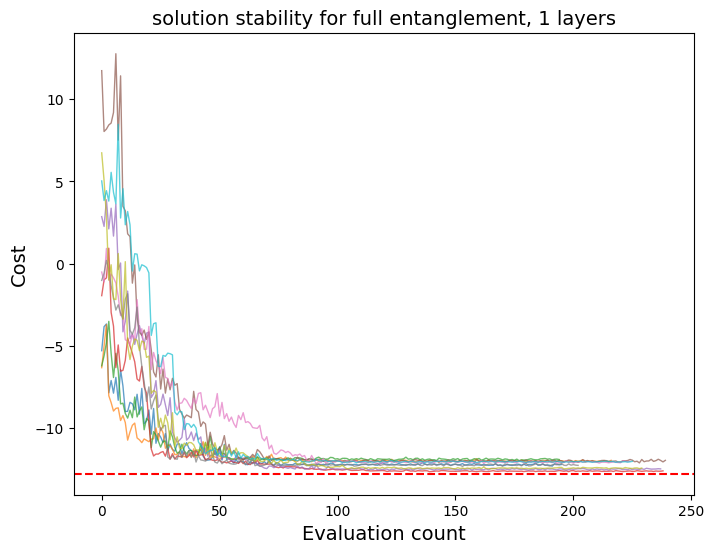

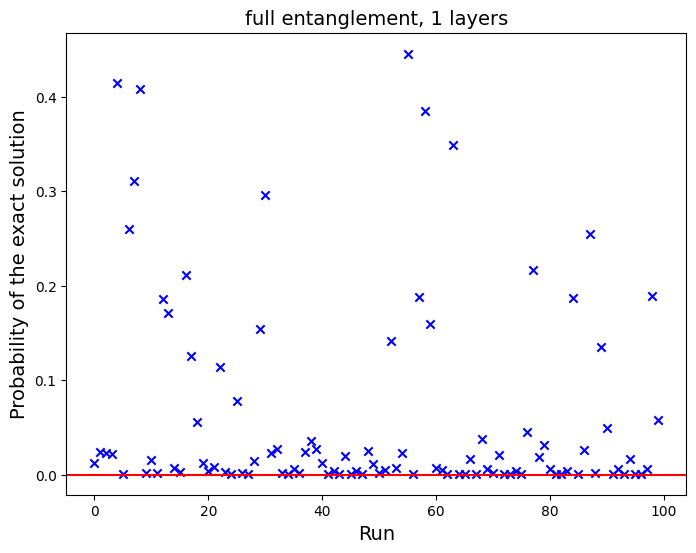

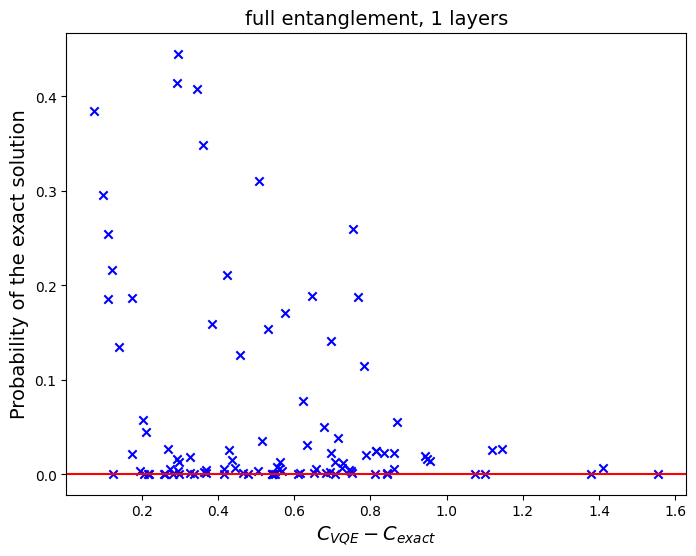

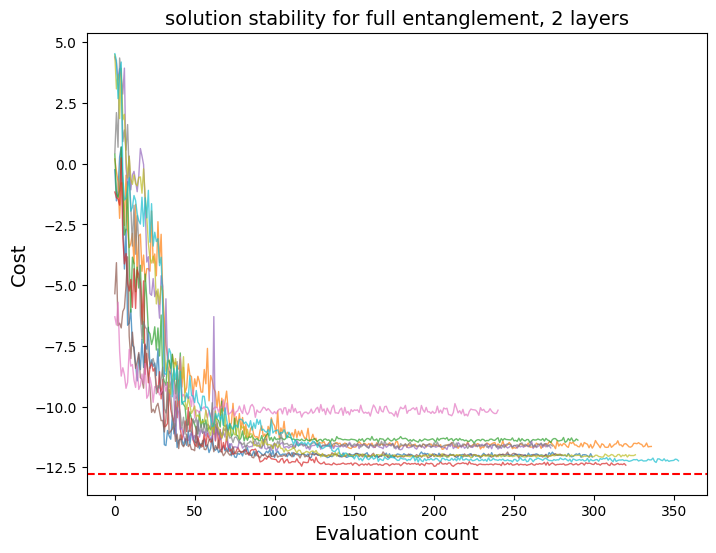

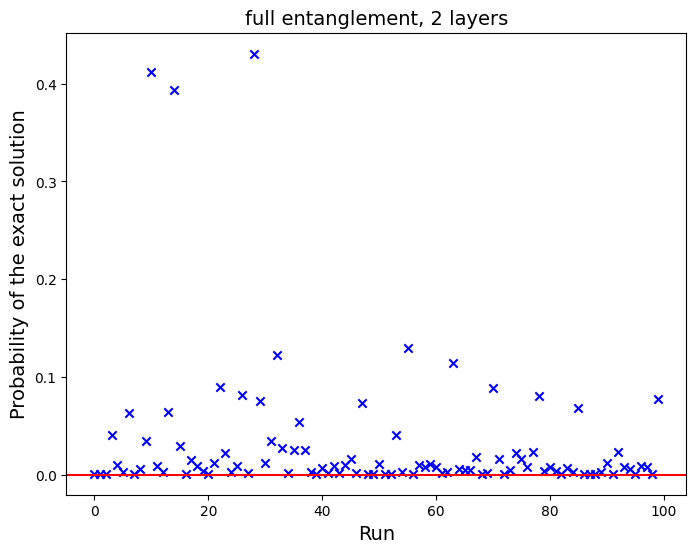

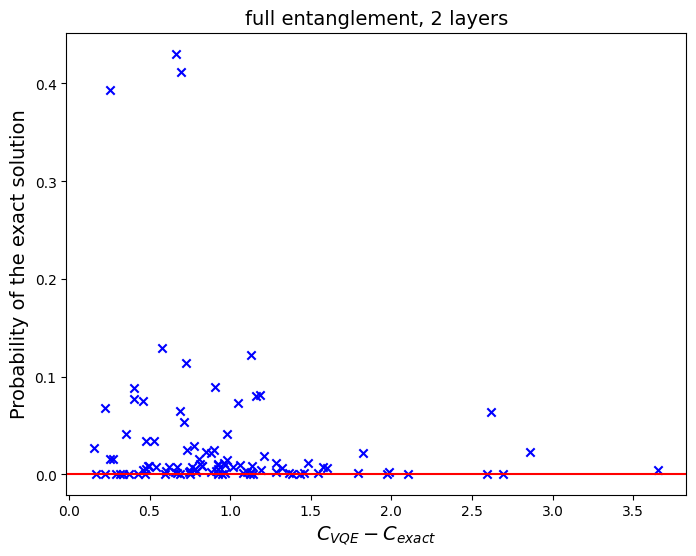

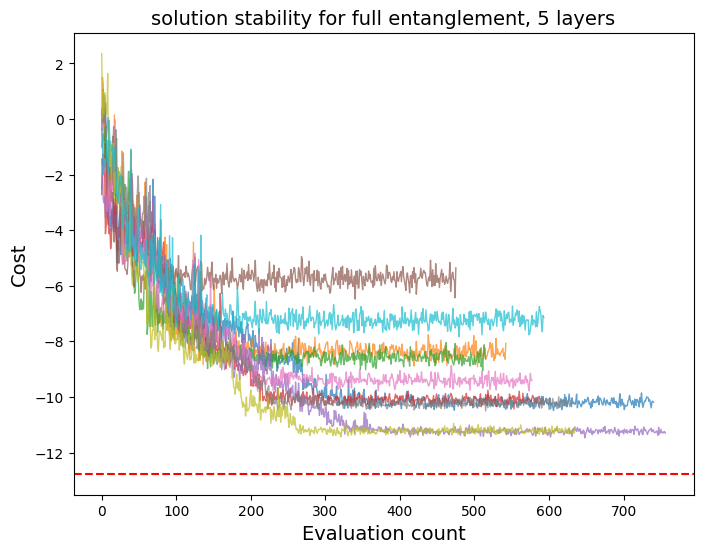

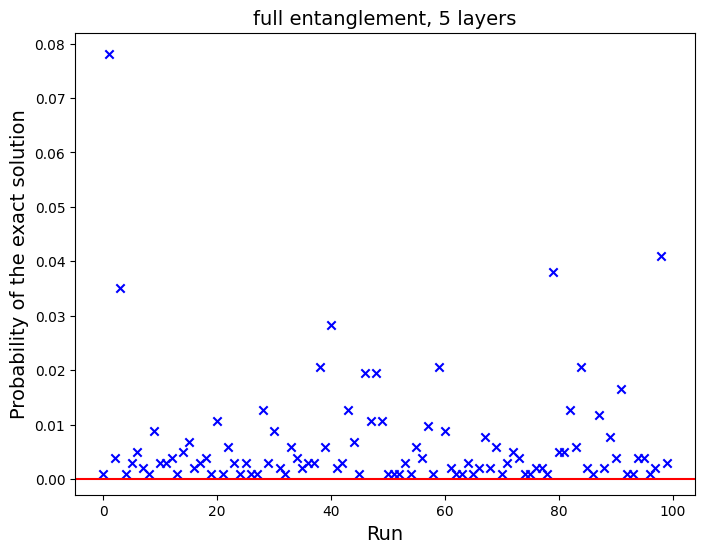

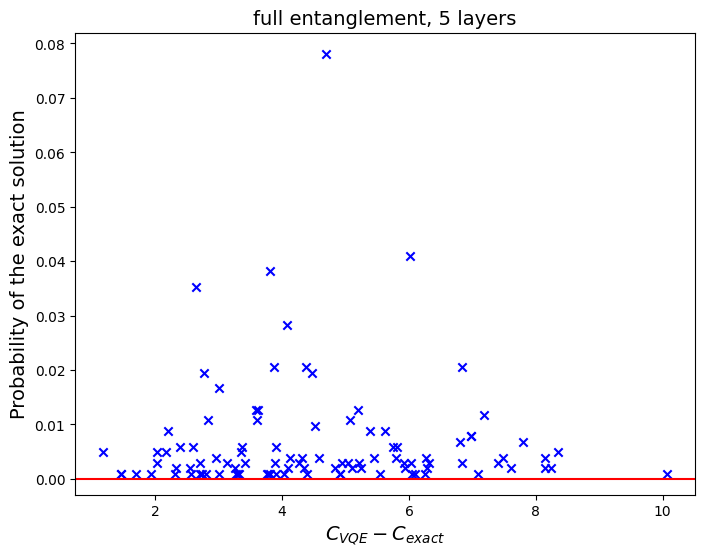

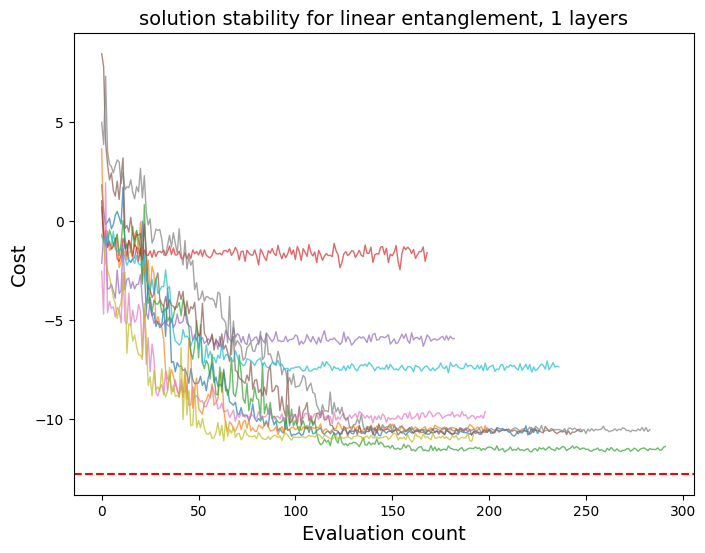

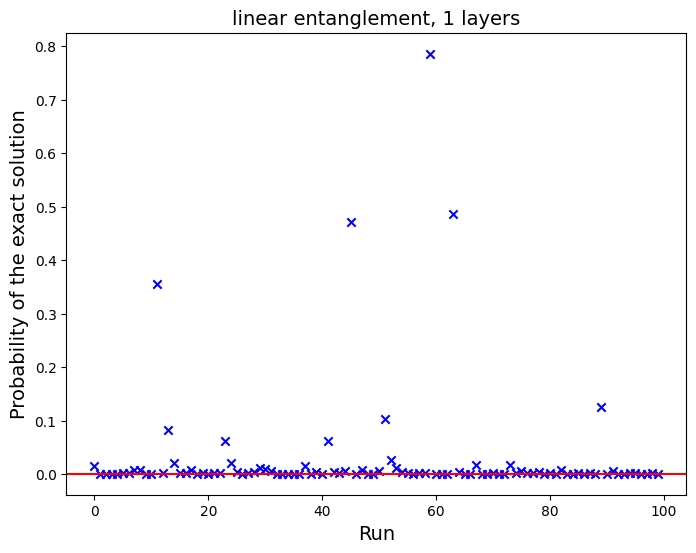

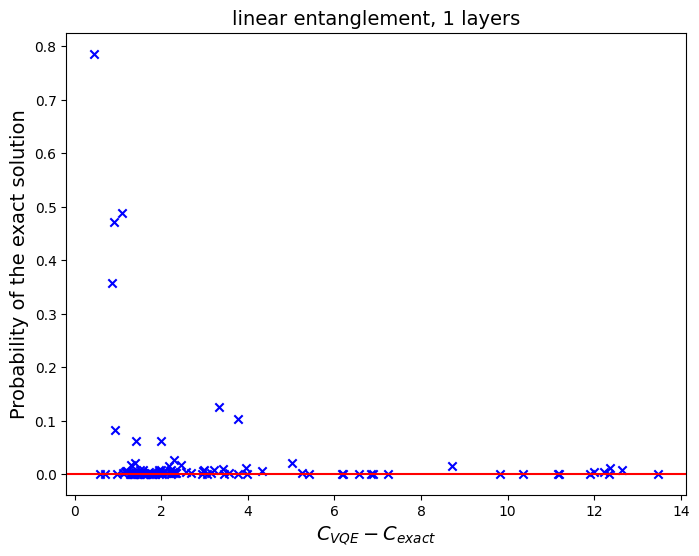

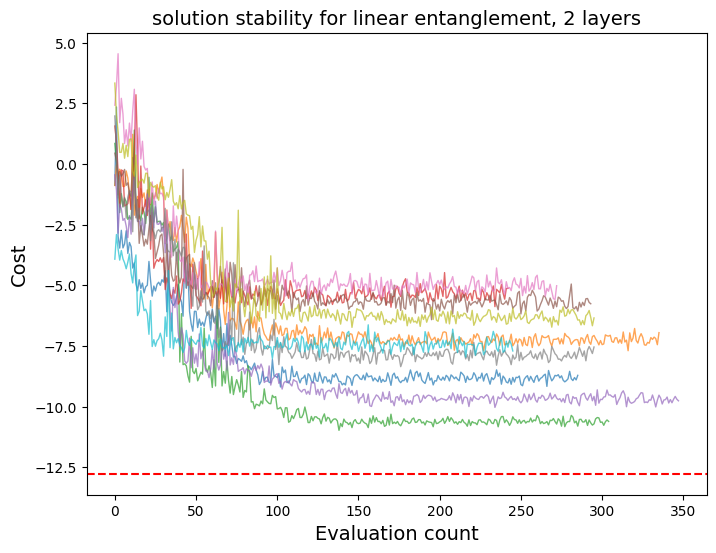

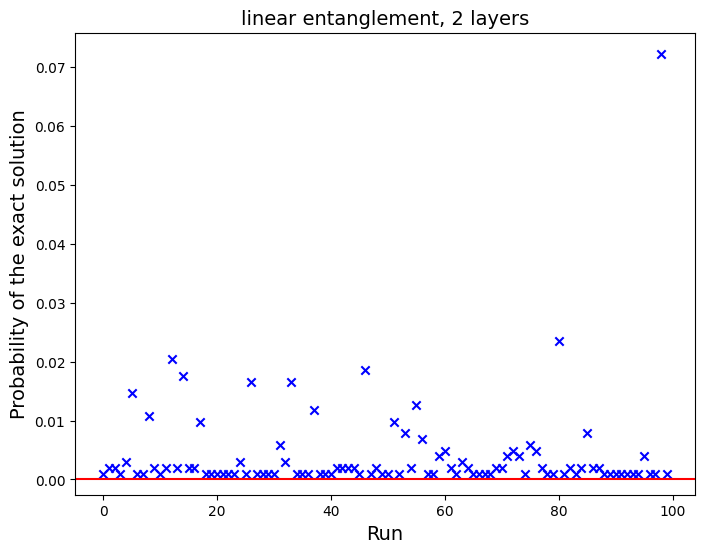

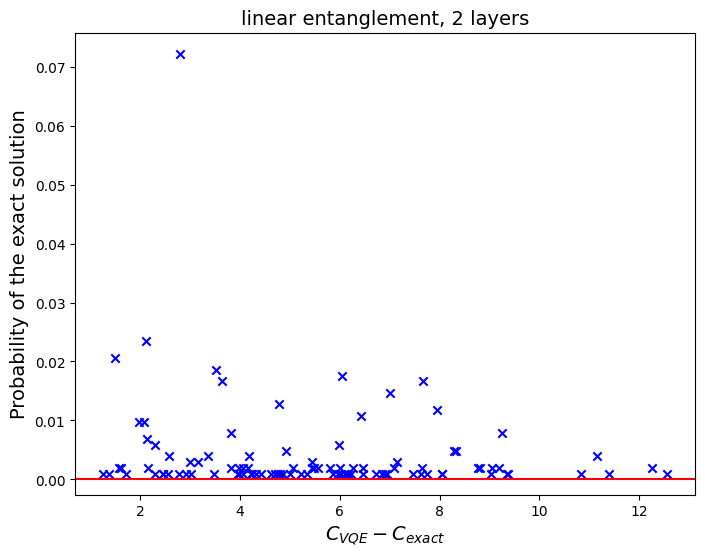

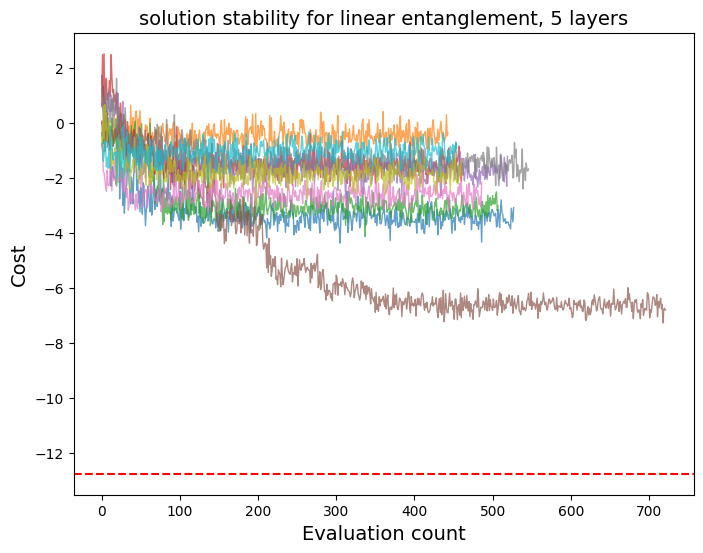

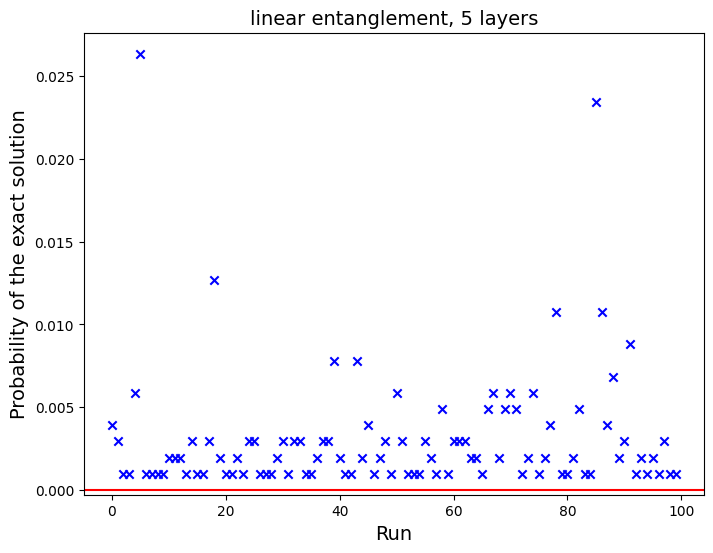

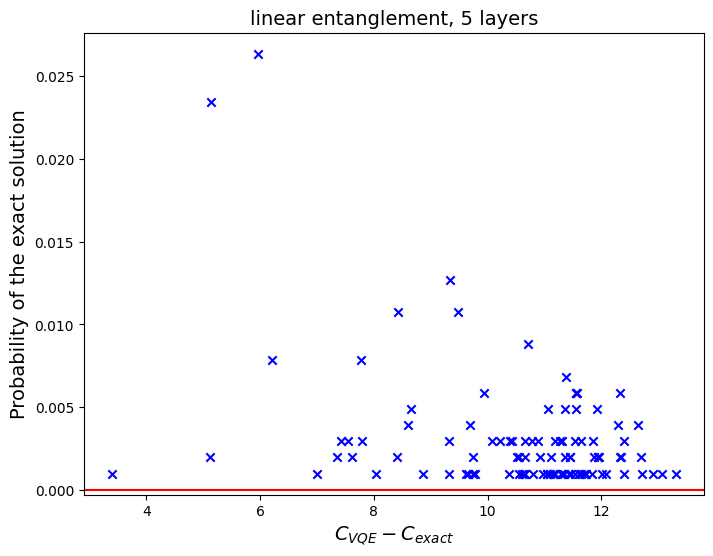

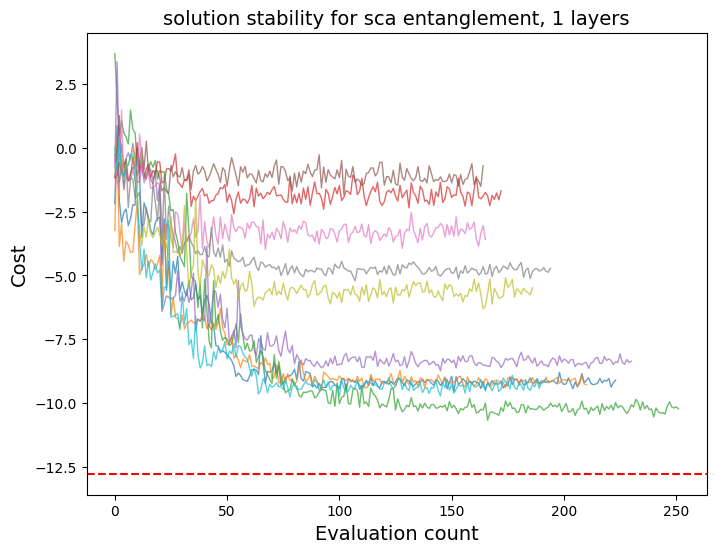

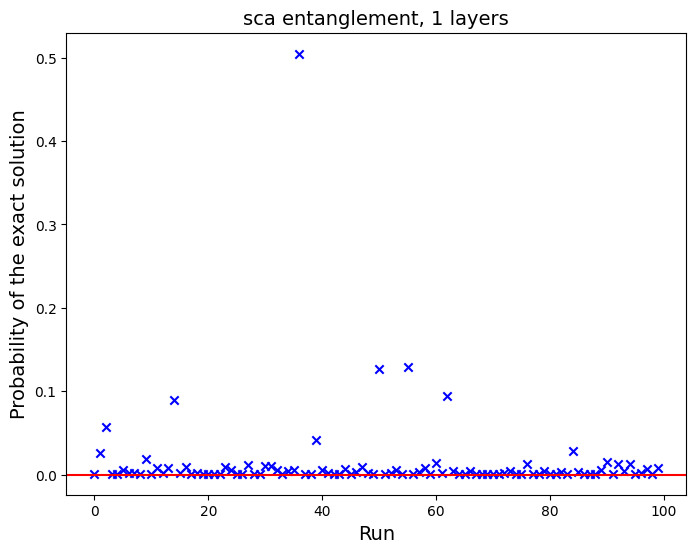

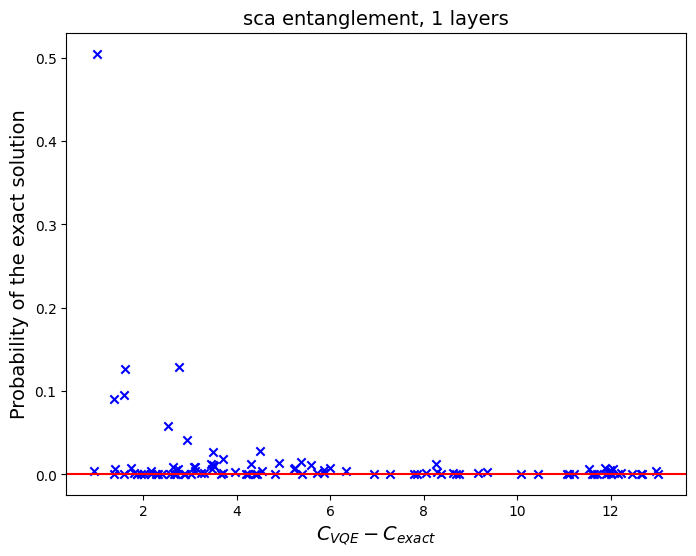

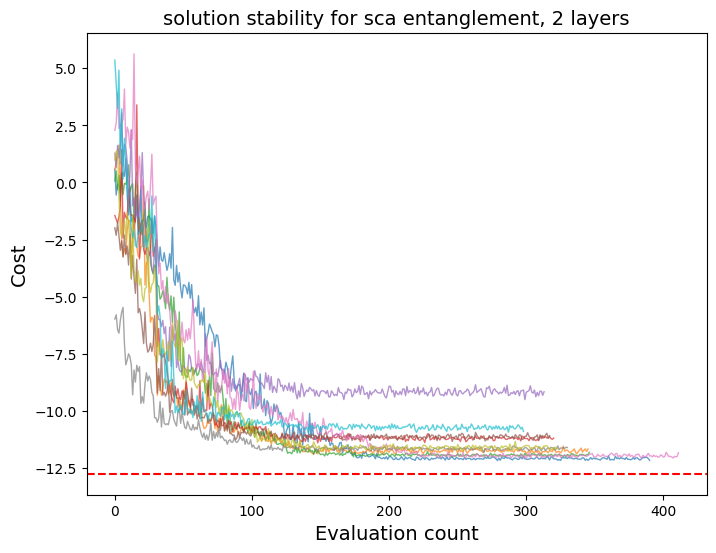

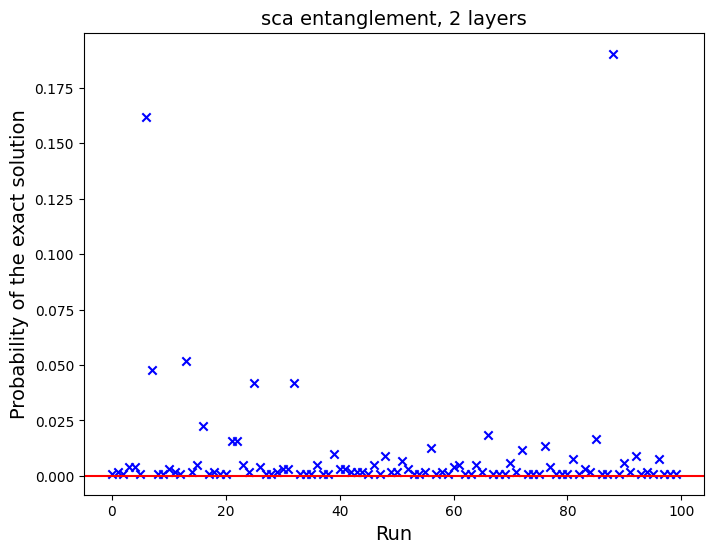

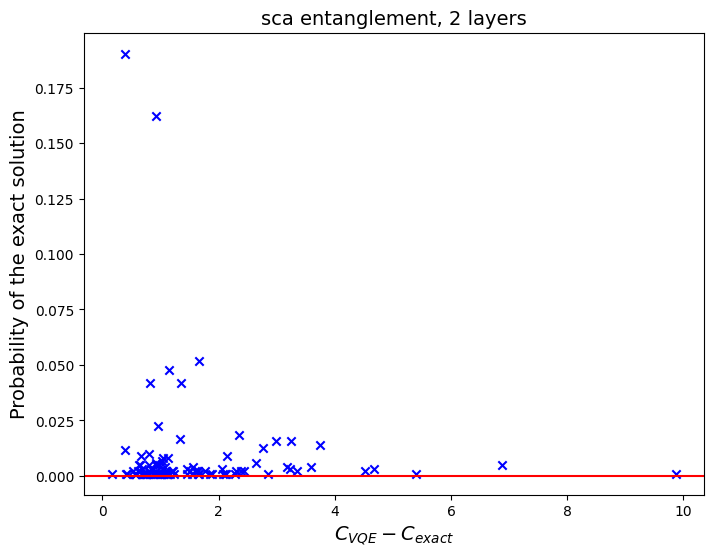

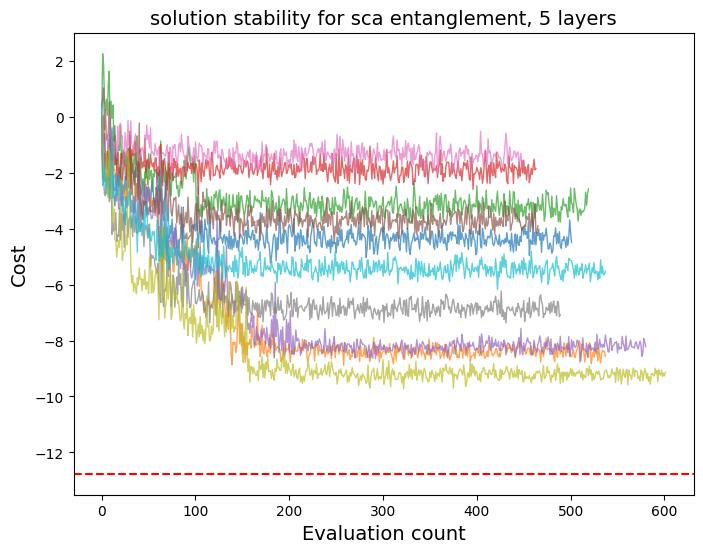

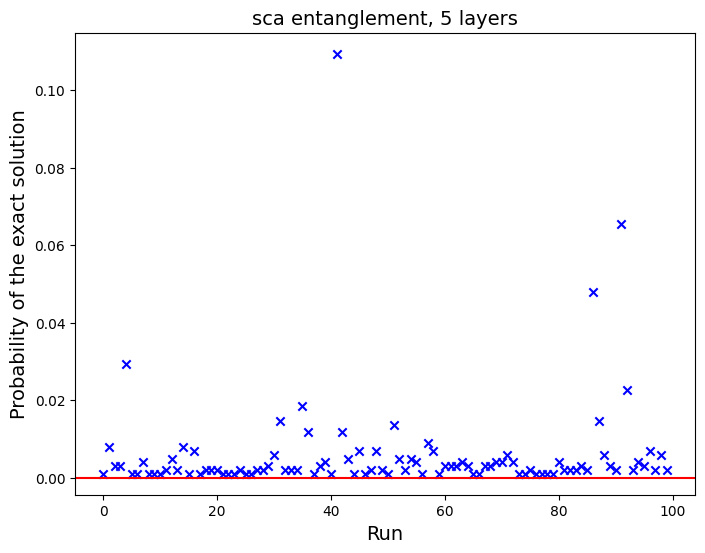

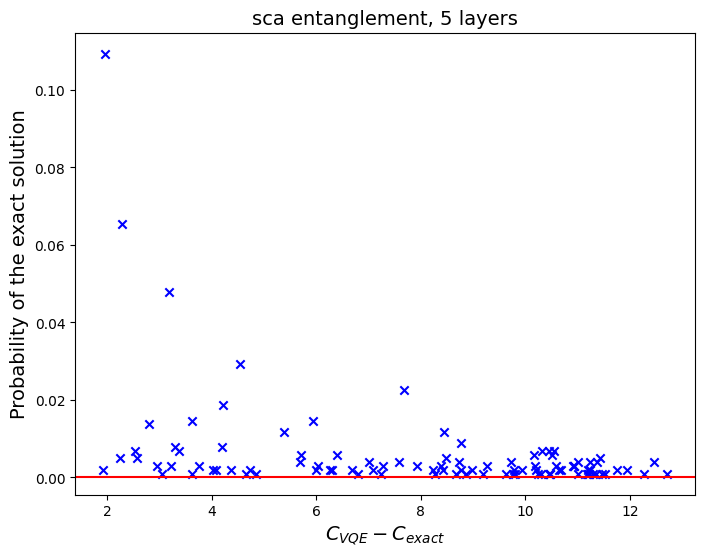

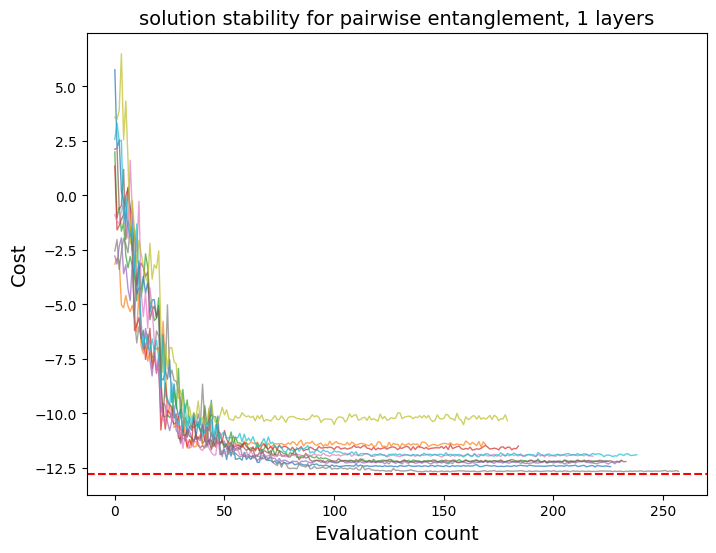

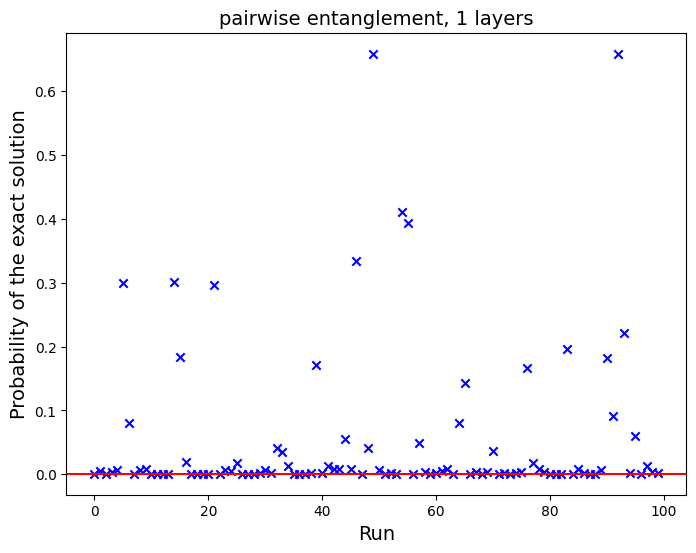

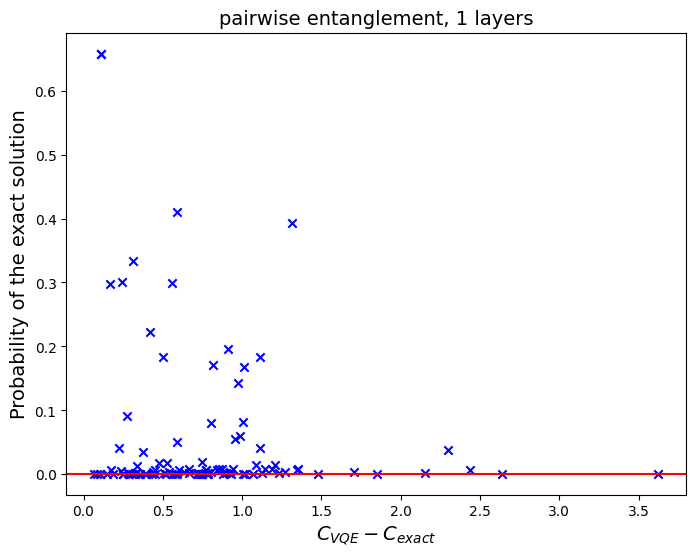

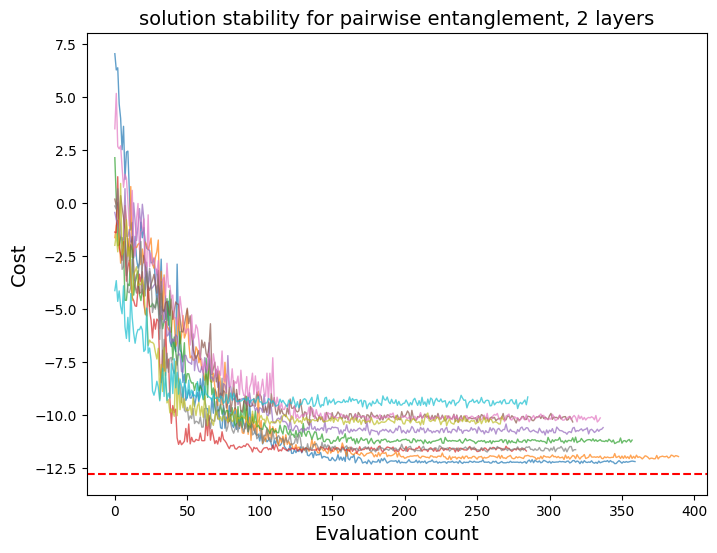

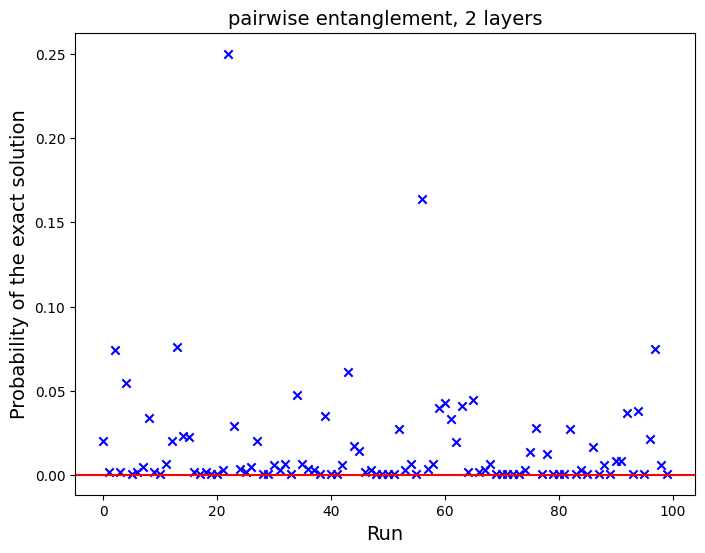

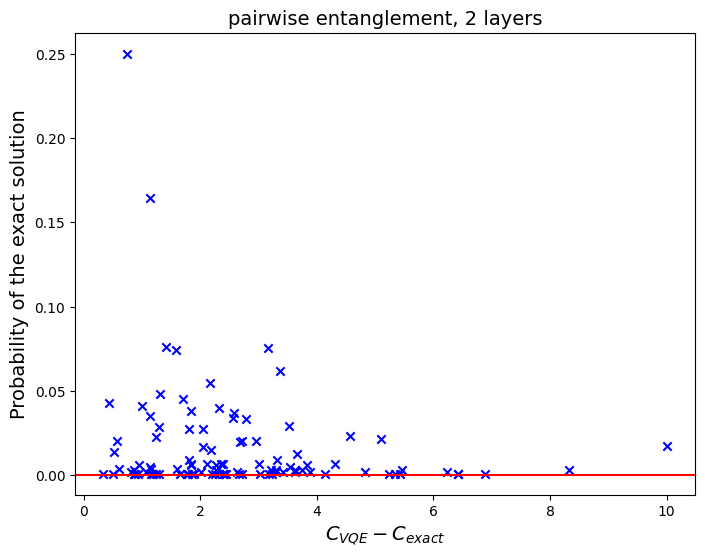

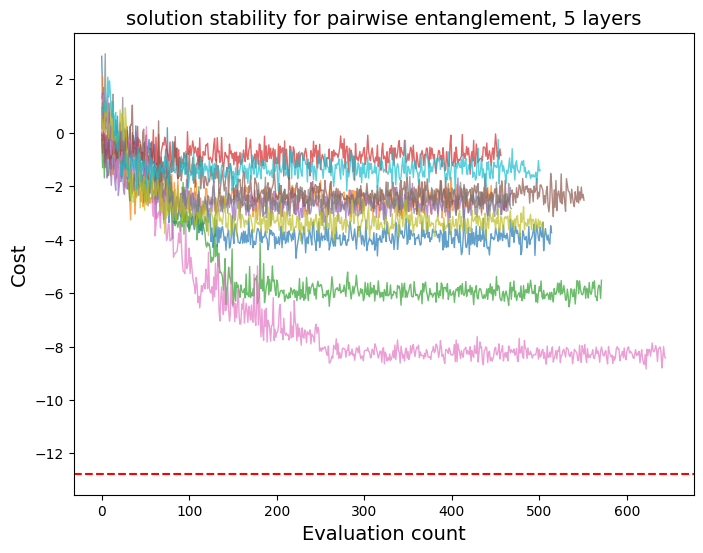

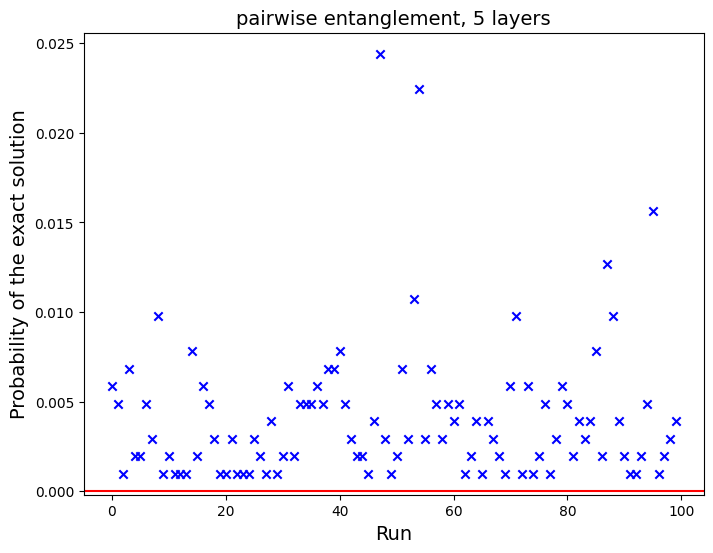

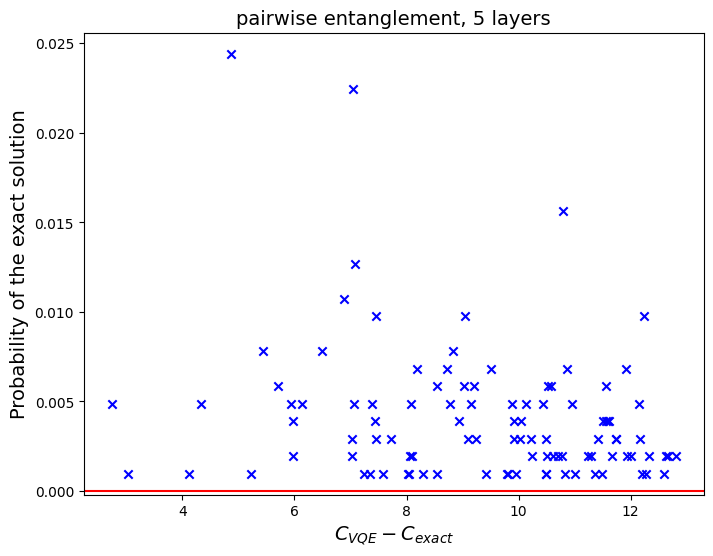

In [20]:
statistics_count = 100

num_assets = 10
save_folder = r"D:/Qiskit hackathon/plots_TwoLocal/solution_stability/"

# Parameters
rotation_blocks = ["y", "rx"]
entanglement_sweep = ["full", "linear", "sca", "pairwise"]
reps_sweep = [1, 2, 5]
entanglement_blocks="ecr"

# Data
qp, data = pseudorandom_to_qp(num_assets=num_assets)

# Exact result via classical eigensolver
result_exact = get_result_numpy(qp)
reference_cost = result_exact.min_eigen_solver_result.eigenvalue.real
reference_fval = result_exact.fval

# Sweep
for i in range(len(entanglement_sweep)):

    entanglement = entanglement_sweep[i]

    for j in range(len(reps_sweep)):

        reps = reps_sweep[j]

        # Make figure for cost plot
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        ax.axhline(reference_cost, color="red", ls="--")

        # Initial values
        prob_vqe_exact = []
        error_vqe_cost = []

        for k in range(statistics_count):

            print('Starting entanglement ', entanglement, ', ', reps, ' layers, run ', k)

            ansatz = TwoLocal(num_qubits=num_assets,rotation_blocks=rotation_blocks, entanglement=entanglement, 
                              reps=reps, entanglement_blocks=entanglement_blocks)
            result_svqe, history = get_result_SamplingVQE(qp, ansatz=ansatz)

             # Probability of the exact solution, error in cost function value
            prob_vqe_exact.append(prob_exact(result_svqe, result_exact))
            error_vqe_cost.append(result_svqe.min_eigen_solver_result.eigenvalue.real - reference_cost)

            # Plot some results
            if k<10:
                ax.plot(history["cost"], lw=1, alpha=0.7)


        # Complete the cost plot
        ax.set_ylabel("Cost", fontsize=14)
        ax.set_xlabel("Evaluation count", fontsize=14)
        ax.set_title(r"solution stability for " + entanglement + r" entanglement, " + str(reps) + " layers", fontsize=14)
        fig.savefig(save_folder + entanglement + r"_" + str(reps) + r"rep_cost.png")

        # Plot the probability of the exact solution as a function of the run, while in each run the initial parameters are the last optimal ones
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        ax.scatter([i for i in range(len(prob_vqe_exact))], prob_vqe_exact, marker="x", color="blue")
        ax.axhline(0, color="red", ls="-")
        ax.set_ylabel("Probability of the exact solution", fontsize=14)
        ax.set_xlabel("Run", fontsize=14)
        ax.set_title(entanglement + r" entanglement, " + str(reps) + " layers", fontsize=14)
        fig.savefig(save_folder + entanglement + r"_" + str(reps) + r"rep_prob_run.png")

        # Plot the probability of the exact solution as a function of the error in the cost function value (compared to the exact solution)
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        ax.scatter(error_vqe_cost, prob_vqe_exact, marker="x", color="blue")
        ax.axhline(0, color="red", ls="-")
        ax.set_ylabel("Probability of the exact solution", fontsize=14)
        ax.set_xlabel("$C_{VQE} - C_{exact}$", fontsize=14)
        ax.set_title(entanglement + r" entanglement, " + str(reps) + " layers", fontsize=14)
        fig.savefig(save_folder + entanglement + r"_" + str(reps) + r"rep_prob_cost.png")


In [ ]:
# Test different entangling gates
statistics_count = 100

num_assets = 10
save_folder = r"D:/Qiskit hackathon/plots_TwoLocal/solution_stability/"

# Parameters
rotation_blocks = ["y", "rx"]
entanglement_sweep = "full"
reps_sweep = [1, 2]
entanglement_blocks_sweep=["ecr", "cz", None]

# Data
qp, data = pseudorandom_to_qp(num_assets=num_assets)

# Exact result via classical eigensolver
result_exact = get_result_numpy(qp)
reference_cost = result_exact.min_eigen_solver_result.eigenvalue.real
reference_fval = result_exact.fval

# Sweep
for i in range(len(entanglement_blocks_sweep)):

    entanglement_blocks = entanglement_blocks_sweep[i]

    for j in range(len(reps_sweep)):

        reps = reps_sweep[j]

        # Make figure for cost plot
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        ax.axhline(reference_cost, color="red", ls="--")

        # Initial values
        prob_vqe_exact = []
        error_vqe_cost = []

        for k in range(statistics_count):

            print('Starting entanglement gate ', entanglement_blocks, ', ', reps, ' layers, run ', k)

            ansatz = TwoLocal(num_qubits=num_assets,rotation_blocks=rotation_blocks, entanglement=entanglement, 
                              reps=reps, entanglement_blocks=entanglement_blocks)
            result_svqe, history = get_result_SamplingVQE(qp, ansatz=ansatz)

             # Probability of the exact solution, error in cost function value
            prob_vqe_exact.append(prob_exact(result_svqe, result_exact))
            error_vqe_cost.append(result_svqe.min_eigen_solver_result.eigenvalue.real - reference_cost)

            # Plot some results
            if k<10:
                ax.plot(history["cost"], lw=1, alpha=0.7)


        # Complete the cost plot
        ax.set_ylabel("Cost", fontsize=14)
        ax.set_xlabel("Evaluation count", fontsize=14)
        ax.set_title(r"solution stability for " + entanglement_blocks + r" ent. gates, " + str(reps) + " layers", fontsize=14)
        fig.savefig(save_folder + entanglement_blocks + r"_" + str(reps) + r"rep_cost.png")

        # Plot the probability of the exact solution as a function of the run, while in each run the initial parameters are the last optimal ones
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        ax.scatter([i for i in range(len(prob_vqe_exact))], prob_vqe_exact, marker="x", color="blue")
        ax.axhline(0, color="red", ls="-")
        ax.set_ylabel("Probability of the exact solution", fontsize=14)
        ax.set_xlabel("Run", fontsize=14)
        ax.set_title(entanglement_blocks + r" ent. gates, " + str(reps) + " layers", fontsize=14)
        fig.savefig(save_folder + entanglement_blocks + r"_" + str(reps) + r"rep_prob_run.png")

        # Plot the probability of the exact solution as a function of the error in the cost function value (compared to the exact solution)
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        ax.scatter(error_vqe_cost, prob_vqe_exact, marker="x", color="blue")
        ax.axhline(0, color="red", ls="-")
        ax.set_ylabel("Probability of the exact solution", fontsize=14)
        ax.set_xlabel("$C_{VQE} - C_{exact}$", fontsize=14)
        ax.set_title(entanglement_blocks + r" ent. gates, " + str(reps) + " layers", fontsize=14)
        fig.savefig(save_folder + entanglement_blocks + r"_" + str(reps) + r"rep_prob_cost.png")


Starting entanglement  full ,  1  layers, run  0
Starting entanglement  full ,  1  layers, run  1
Starting entanglement  full ,  1  layers, run  2
Starting entanglement  full ,  1  layers, run  3


KeyboardInterrupt: 

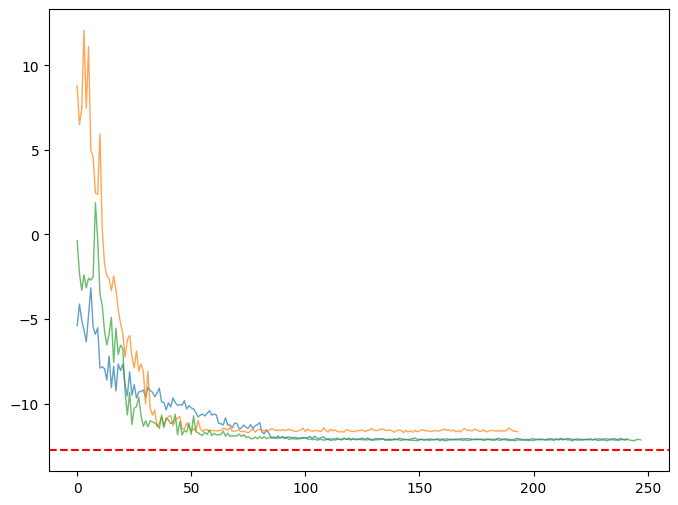

In [26]:
statistics_count = 100

num_assets = 10
save_folder = r"D:/Qiskit hackathon/plots_TwoLocal/solution"

# Parameters
rotation_blocks = ["y", "rx"]# ["rx", "y"]
entanglement = "full"# , "linear", "sca", "pairwise"]
reps = 1

# Data
qp, data = pseudorandom_to_qp(num_assets=num_assets)

# Exact result via classical eigensolver
result_exact = get_result_numpy(qp)
reference_cost = result_exact.min_eigen_solver_result.eigenvalue.real
reference_fval = result_exact.fval

# Make figure for cost plot
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.axhline(reference_cost, color="red", ls="--")

# Initial values
# evals_temp = np.array([])
# mean_error_fval[i, j] = 0
prob_vqe_exact = []
error_vqe_cost = []

for k in range(statistics_count):

    print('Starting entanglement ', entanglement, ', ', reps, ' layers, run ', k)

    ansatz = TwoLocal(num_qubits=num_assets,rotation_blocks=rotation_blocks, entanglement=entanglement, reps=reps)
    
    initial_param = [0 for i in range(len(ansatz.parameters))]

    result_svqe, history = get_result_SamplingVQE(qp, ansatz=ansatz)

    # Probability of the exact solution, error in cost function value
    prob_vqe_exact.append(prob_exact(result_svqe, result_exact))
    error_vqe_cost.append(result_svqe.min_eigen_solver_result.eigenvalue.real - reference_cost)

    # evals_temp = np.append(evals_temp, result_svqe.min_eigen_solver_result.eigenvalue.real)
    # mean_error_fval[i, j] += result_svqe.fval

    # Plot some results
    if k<10:
        ax.plot(history["cost"], lw=1, alpha=0.7)

# Compute statistics
# mean_evals[i, j] = np.mean(evals_temp)
# std_evals[i, j] = np.std(evals_temp)
# mean_error_fval[i, j] /= statistics_count

# Complete the cost plot
ax.set_ylabel("Cost", fontsize=14)
ax.set_xlabel("Evaluation count", fontsize=14)
ax.set_title(r"solution stability for " + entanglement + r" entanglement, " + str(reps) + " layers", fontsize=14)
fig.savefig(save_folder + entanglement + r"_" + str(reps) + r"rep_cost.png")

# Plot the probability of the exact solution as a function of the error in the cost function value (compared to the exact solution)
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.scatter(error_vqe_cost, prob_vqe_exact, marker="x", color="blue")
ax.axhline(0, color="red", ls="-")
ax.set_ylabel("Probability of the exact solution", fontsize=14)
ax.set_xlabel("$C_{VQE} - C_{exact}$", fontsize=14)
ax.set_title(entanglement + r" entanglement, " + str(reps) + " layers", fontsize=14)
fig.savefig(save_folder + entanglement + r"_" + str(reps) + r"rep_prob.png")


# Ansatz visualizer

In [48]:
from qiskit.circuit.library import QAOAAnsatz

ansatz = QAOAAnsatz(reps=1)
ansatz.decompose().draw(output="mpl", idle_wires=False, style="iqp")



ValueError: The operator representing the cost of the optimization problem is not set

# QAOA: ideal simulation

In [108]:
def get_result_QAOA(
    qp,
    optimizer=COBYLA(),
    reps = 1
):
    cost_history_dict = {
        "params": [],
        "cost": [],
        "meta": []
    }

    # Define the callback function to capture the cost value at each iteration
    def store_cost(eval_count, params, value, meta):
        cost_history_dict["params"].append(params)
        cost_history_dict["cost"].append(value.real)
        cost_history_dict["meta"].append(meta)


    qaoa_mes = QAOA(sampler = Sampler(), optimizer=optimizer, reps=reps, callback= store_cost)
    qaoa = MinimumEigenOptimizer(qaoa_mes)
    result = qaoa.solve(qp)
    return result, cost_history_dict


Starting  1  layers, run  0


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  1


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  2


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  3


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  4


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  5


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  6


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  7


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  8


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  9


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  10


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  11


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  12


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  13


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  14


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  15


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  16


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  17


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  18


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  19


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  20


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  21


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  22


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  23


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  24


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  25


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  26


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  27


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  28


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  29


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  30


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  31


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  32


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  33


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  34


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  35


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  36


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  37


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  38


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  39


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  40


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  41


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  42


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  43


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  44


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  45


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  46


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  47


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  48


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  49


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  50


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  51


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  52


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  53


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  54


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  55


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  56


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  57


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  58


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  59


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  60


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  61


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  62


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  63


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  64


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  65


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  66


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  67


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  68


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  69


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  70


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  71


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  72


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  73


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  74


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  75


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  76


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  77


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  78


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  79


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  80


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  81


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  82


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  83


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  84


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  85


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  86


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  87


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  88


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  89


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  90


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  91


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  92


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  93


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  94


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  95


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  96


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  97


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  98


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  1  layers, run  99


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  0


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  1


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  2


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  3


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  4


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  5


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  6


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  7


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  8


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  9


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  10


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  11


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  12


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  13


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  14


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  15


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  16


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  17


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  18


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  19


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  20


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  21


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  22


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  23


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  24


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  25


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  26


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  27


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  28


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  29


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  30


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  31


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  32


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  33


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  34


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  35


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  36


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  37


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  38


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  39


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  40


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  41


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  42


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  43


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  44


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  45


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  46


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  47


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  48


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  49


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  50


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  51


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  52


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  53


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  54


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  55


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  56


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  57


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  58


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  59


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  60


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  61


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  62


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  63


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  64


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  65


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  66


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  67


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  68


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  69


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  70


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  71


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  72


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  73


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  74


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  75


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  76


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  77


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  78


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  79


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  80


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  81


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  82


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  83


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  84


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  85


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  86


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  87


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  88


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  89


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  90


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  91


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  92


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  93


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  94


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  95


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  96


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  97


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  98


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  2  layers, run  99


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  0


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  1


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  2


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  3


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  4


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  5


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  6


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  7


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  8


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  9


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  10


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  11


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  12


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  13


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  14


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  15


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  16


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  17


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  18


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  19


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  20


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  21


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  22


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  23


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  24


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  25


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  26


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  27


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  28


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  29


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  30


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  31


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  32


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  33


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  34


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  35


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  36


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  37


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  38


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  39


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  40


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  41


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  42


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  43


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  44


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  45


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  46


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  47


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  48


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  49


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  50


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  51


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  52


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  53


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  54


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  55


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  56


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  57


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  58


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  59


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  60


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  61


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  62


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  63


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  64


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  65


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  66


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  67


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  68


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  69


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  70


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  71


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  72


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  73


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  74


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  75


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  76


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  77


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  78


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  79


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  80


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  81


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  82


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  83


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  84


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  85


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  86


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  87


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  88


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  89


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  90


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  91


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  92


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  93


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  94


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  95


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  96


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  97


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  98


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  3  layers, run  99


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  0


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  1


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  2


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  3


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  4


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  5


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  6


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  7


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  8


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  9


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  10


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  11


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  12


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  13


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  14


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  15


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  16


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  17


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  18


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  19


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  20


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  21


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  22


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  23


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  24


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  25


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  26


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  27


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  28


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  29


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  30


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  31


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  32


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  33


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  34


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  35


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  36


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  37


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  38


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  39


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  40


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  41


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  42


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  43


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  44


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  45


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  46


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  47


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  48


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  49


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  50


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  51


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  52


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  53


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  54


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  55


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  56


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  57


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  58


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  59


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  60


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  61


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  62


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  63


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  64


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  65


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  66


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  67


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  68


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  69


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  70


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  71


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  72


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  73


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  74


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  75


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  76


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  77


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  78


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  79


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  80


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  81


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  82


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  83


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  84


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  85


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  86


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  87


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  88


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  89


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  90


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  91


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  92


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  93


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  94


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  95


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  96


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  97


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  98


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  4  layers, run  99


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  0


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  1


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  2


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  3


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  4


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  5


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  6


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  7


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  8


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  9


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  10


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  11


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  12


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  13


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  14


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  15


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  16


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  17


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  18


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  19


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  20


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  21


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  22


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  23


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  24


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  25


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  26


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  27


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  28


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  29


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  30


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  31


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  32


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  33


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  34


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  35


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  36


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  37


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  38


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  39


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  40


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  41


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  42


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  43


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  44


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  45


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  46


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  47


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  48


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  49


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  50


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  51


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  52


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  53


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  54


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  55


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  56


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  57


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  58


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  59


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  60


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  61


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  62


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  63


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  64


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  65


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  66


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  67


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  68


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  69


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  70


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  71


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  72


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  73


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  74


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  75


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  76


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  77


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  78


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  79


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  80


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  81


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  82


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  83


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  84


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  85


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  86


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  87


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  88


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  89


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  90


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  91


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  92


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  93


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  94


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  95


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  96


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  97


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  98


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  5  layers, run  99


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  0


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  1


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  2


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  3


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  4


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  5


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  6


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  7


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  8


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  9


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  10


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  11


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  12


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  13


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  14


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  15


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  16


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  17


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  18


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  19


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  20


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  21


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  22


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  23


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  24


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  25


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  26


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  27


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  28


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  29


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  30


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  31


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  32


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  33


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  34


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  35


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  36


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  37


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  38


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  39


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  40


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  41


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  42


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  43


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  44


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  45


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  46


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  47


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  48


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  49


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  50


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  51


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  52


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  53


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  54


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  55


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  56


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  57


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  58


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  59


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  60


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  61


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  62


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  63


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  64


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  65


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  66


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  67


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  68


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  69


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  70


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  71


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  72


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  73


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  74


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  75


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  76


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  77


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  78


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  79


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  80


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  81


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  82


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  83


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  84


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  85


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  86


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  87


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  88


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  89


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  90


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  91


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  92


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  93


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  94


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  95


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  96


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  97


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  98


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  6  layers, run  99


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  0


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  1


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  2


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  3


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  4


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  5


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  6


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  7


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  8


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  9


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  10


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  11


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  12


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  13


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  14


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  15


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  16


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  17


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  18


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  19


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  20


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  21


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  22


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  23


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  24


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  25


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  26


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  27


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  28


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  29


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  30


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  31


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  32


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  33


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  34


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  35


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  36


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  37


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  38


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  39


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  40


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  41


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  42


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  43


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  44


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  45


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  46


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  47


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  48


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  49


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  50


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  51


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  52


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  53


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  54


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  55


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  56


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  57


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  58


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  59


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  60


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  61


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  62


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  63


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  64


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  65


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  66


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  67


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  68


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  69


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  70


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  71


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  72


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  73


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  74


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  75


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  76


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  77


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  78


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  79


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  80


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  81


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  82


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  83


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  84


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  85


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  86


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  87


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  88


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  89


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  90


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  91


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  92


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  93


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  94


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  95


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  96


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  97


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  98


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)


Starting  7  layers, run  99


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:34: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  result_svqe, history = get_result_QAOA(qp, reps=reps)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_17876\3061792937.py:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 1, figsize=(8, 6))


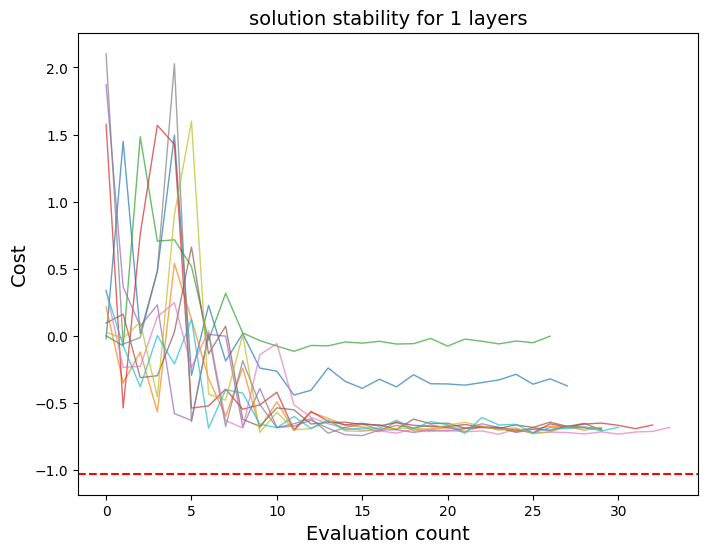

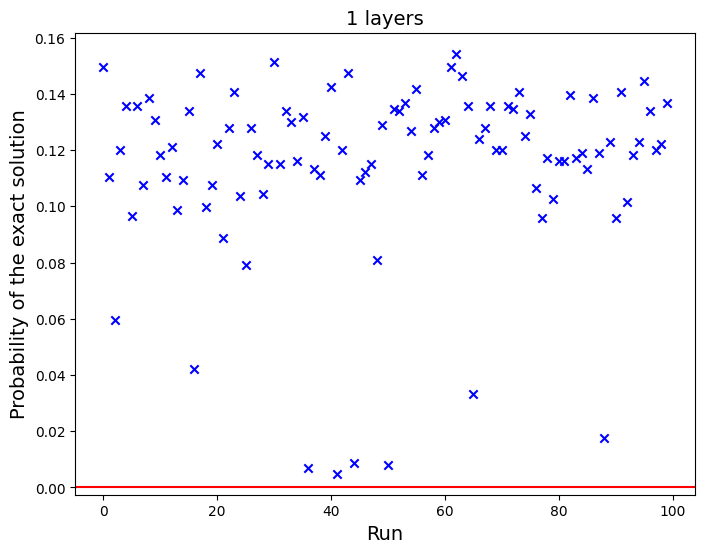

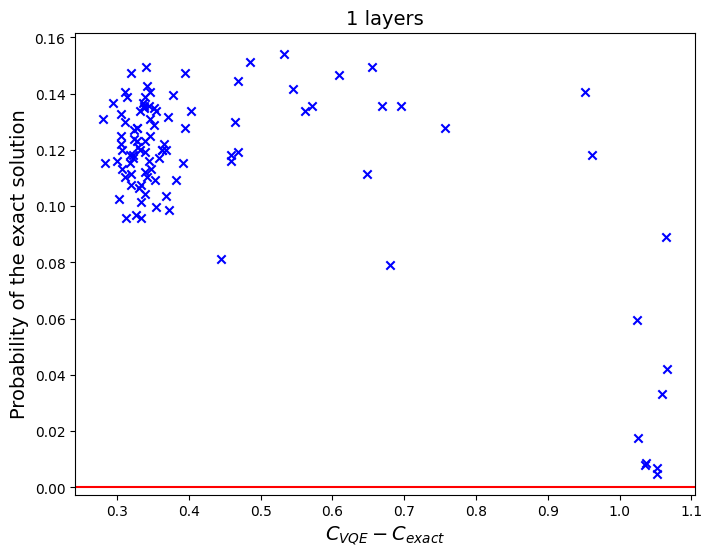

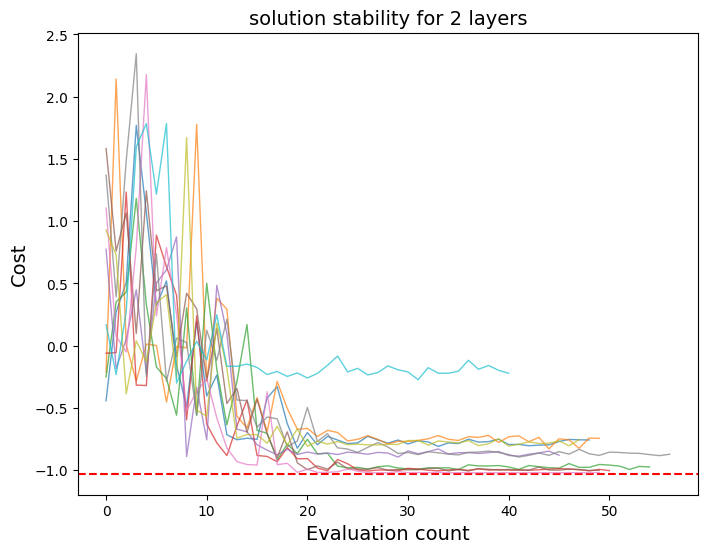

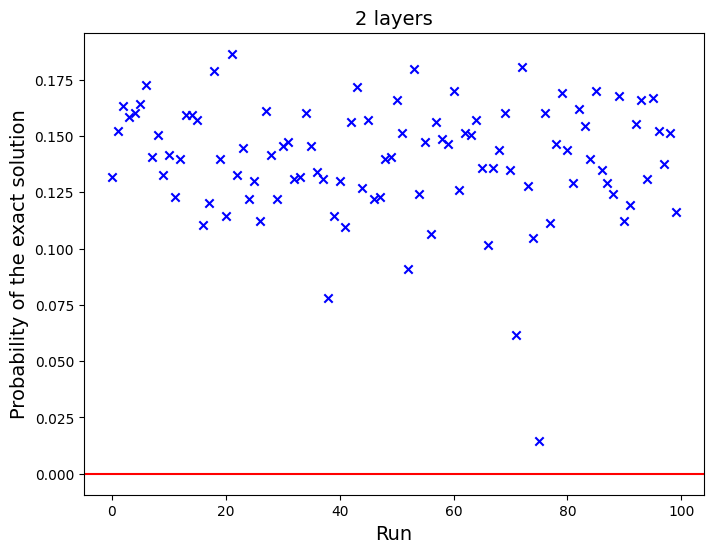

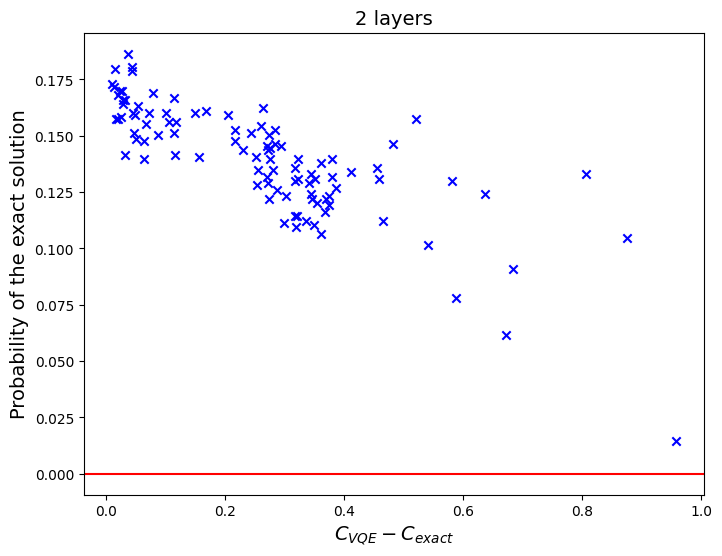

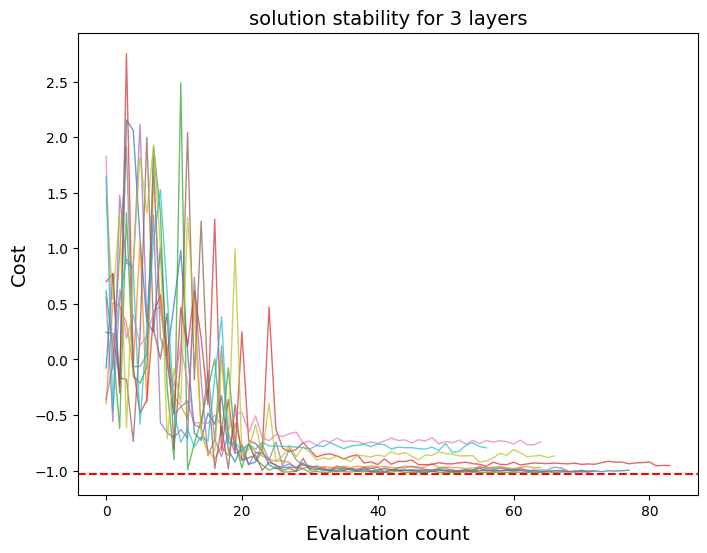

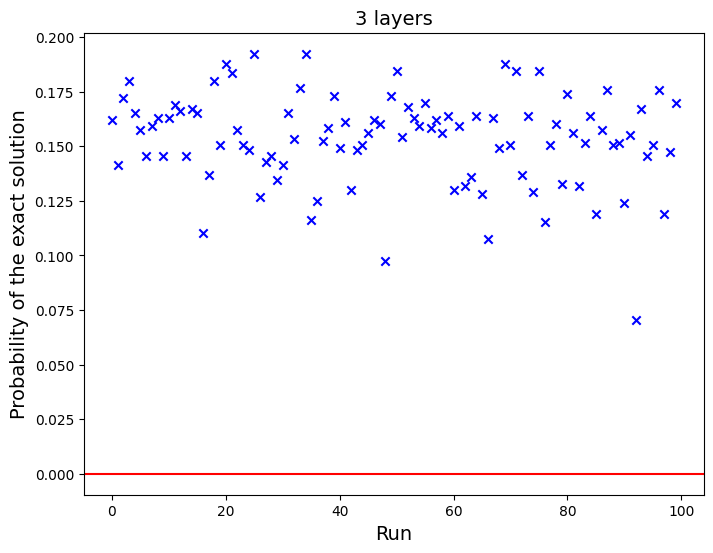

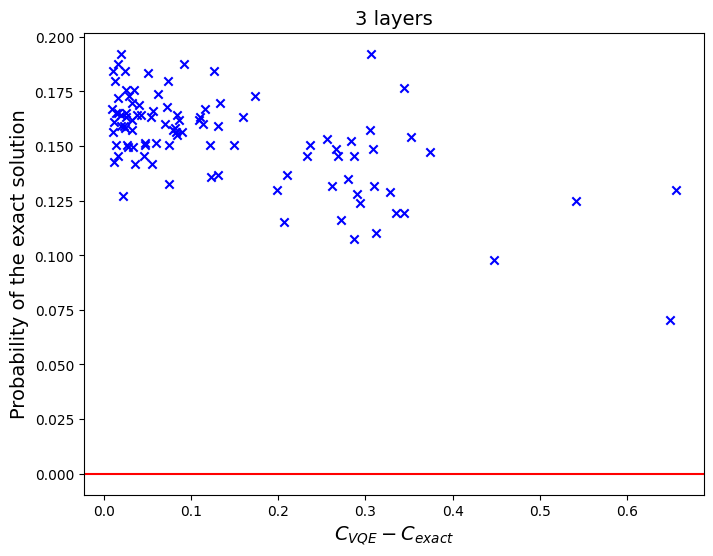

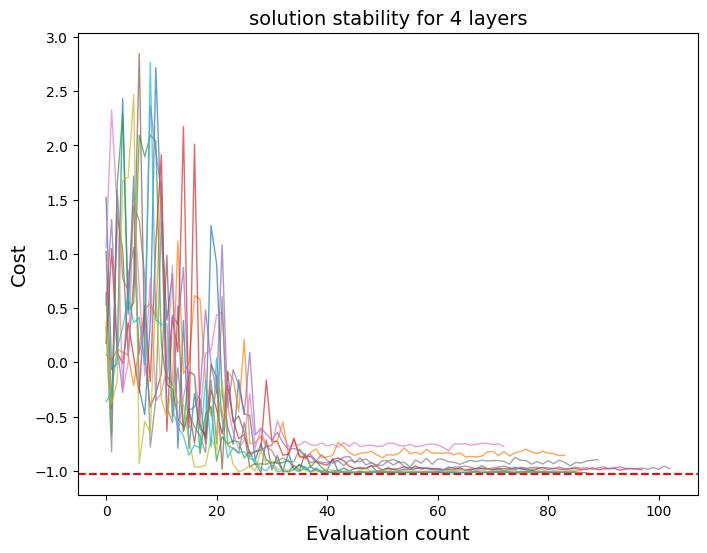

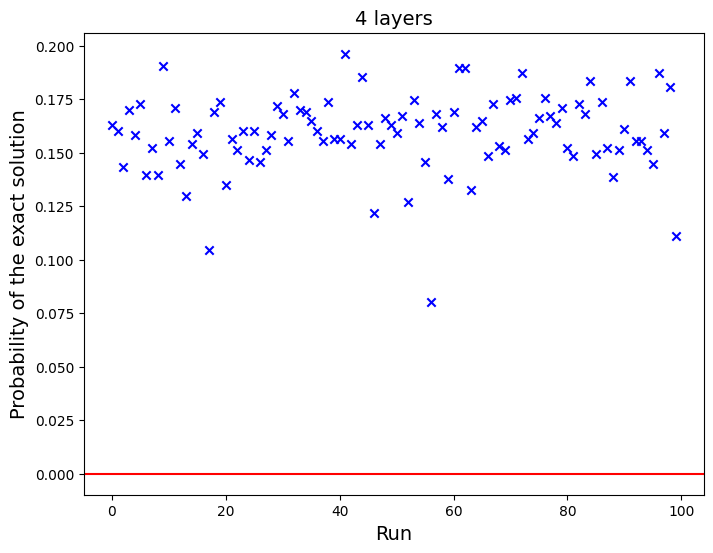

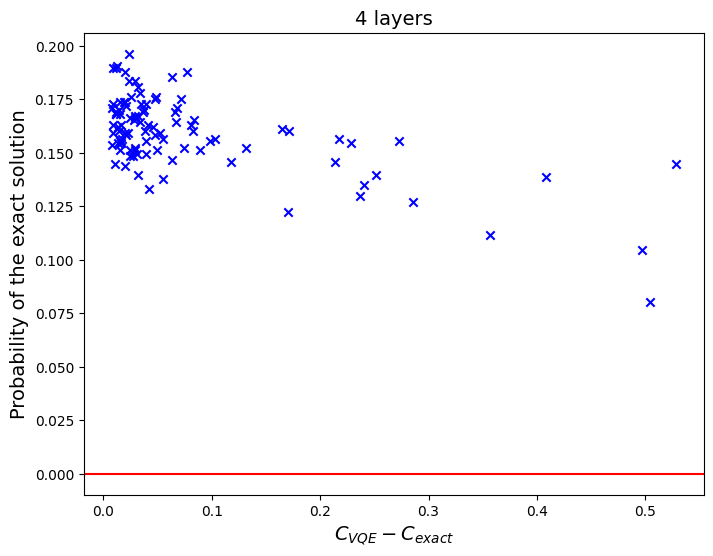

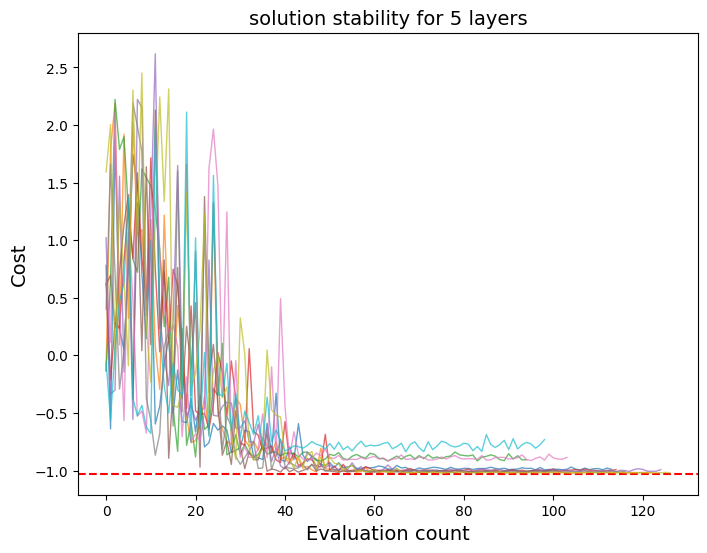

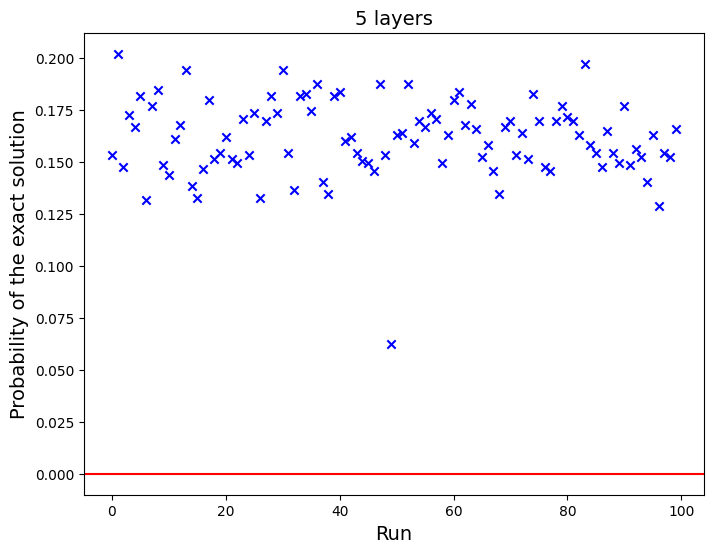

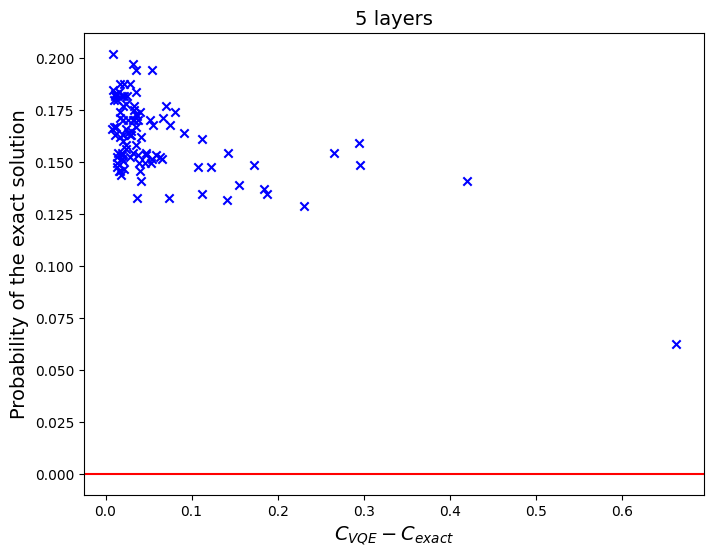

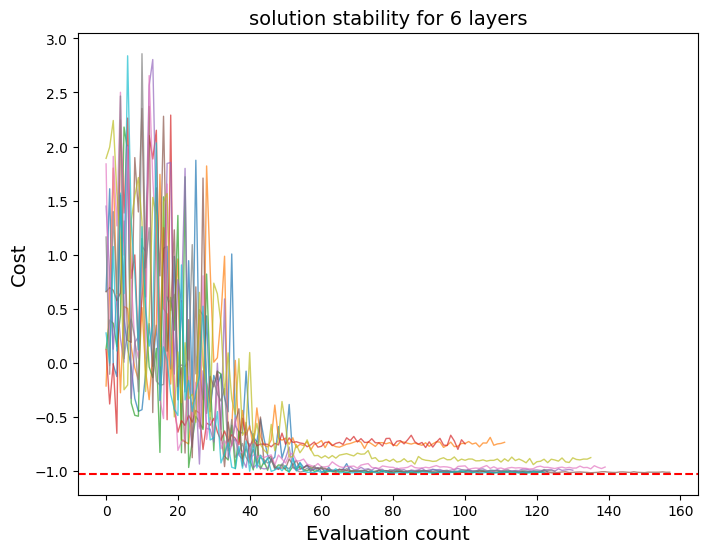

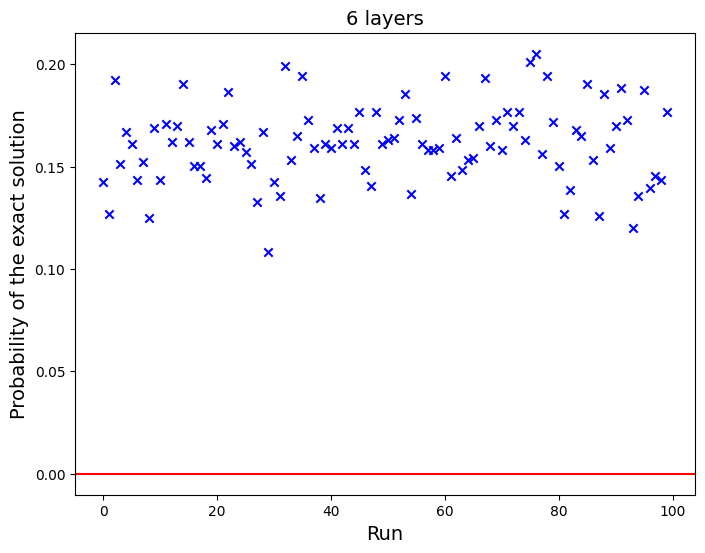

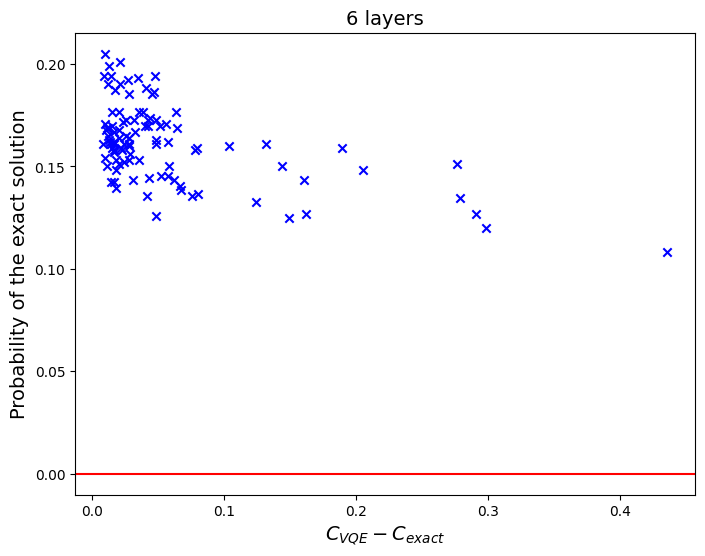

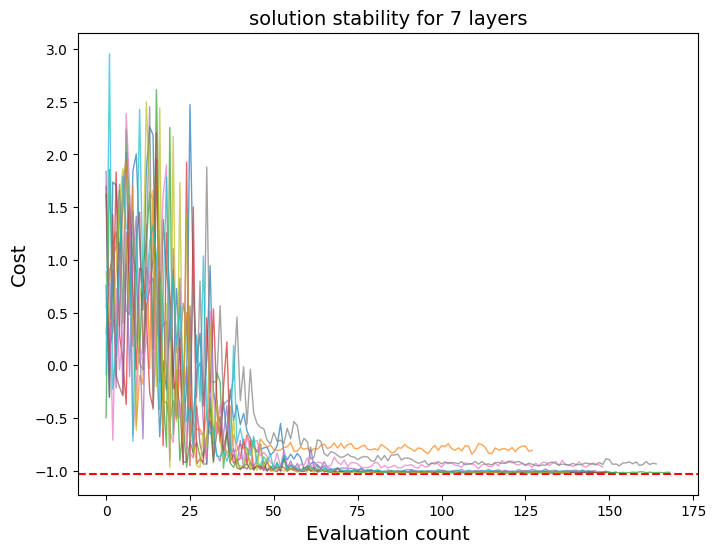

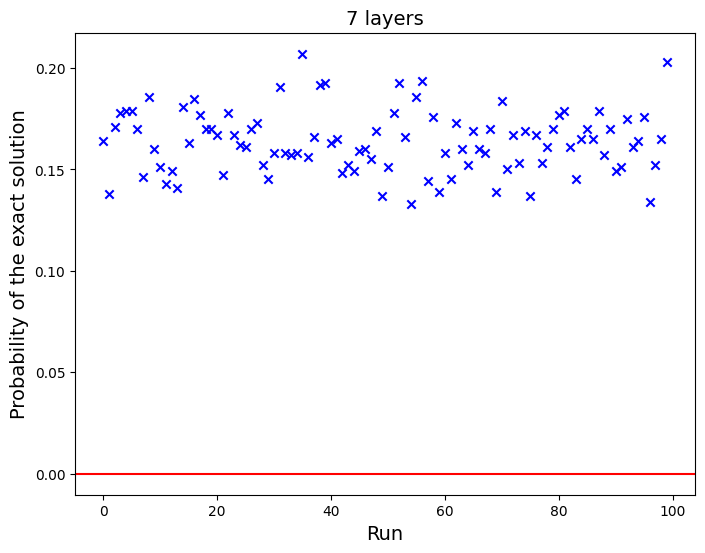

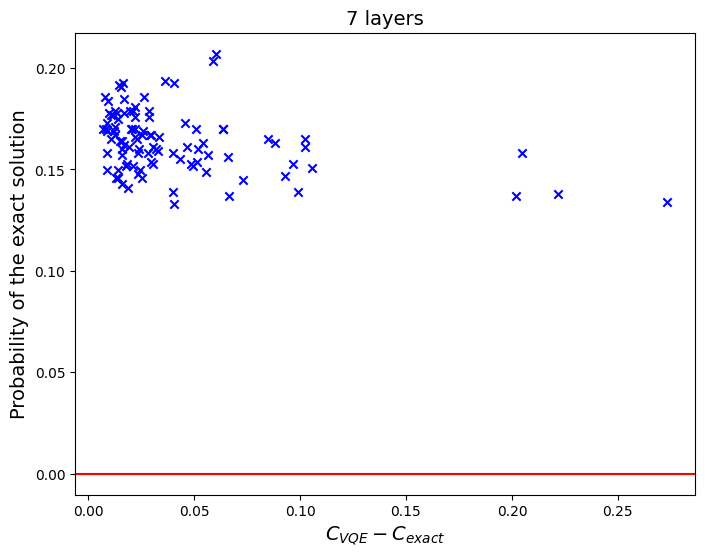

In [109]:
statistics_count = 100

num_assets = 4
save_folder = r"D:/Qiskit hackathon/plots_QAOA/solution_stability/"

# Parameters
reps_sweep = [1, 2, 3, 4, 5, 6, 7]

# Data
qp, data = pseudorandom_to_qp(num_assets=num_assets)

# Exact result via classical eigensolver
result_exact = get_result_numpy(qp)
reference_cost = result_exact.min_eigen_solver_result.eigenvalue.real
reference_fval = result_exact.fval

# Sweep
for i in range(len(reps_sweep)):

    reps = reps_sweep[i]

    # Make figure for cost plot
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.axhline(reference_cost, color="red", ls="--")

    # Initial values
    prob_vqe_exact = []
    error_vqe_cost = []

    for k in range(statistics_count):

        print('Starting ', reps, ' layers, run ', k)

        result_svqe, history = get_result_QAOA(qp, reps=reps)

            # Probability of the exact solution, error in cost function value
        prob_vqe_exact.append(prob_exact(result_svqe, result_exact))
        error_vqe_cost.append(result_svqe.min_eigen_solver_result.eigenvalue.real - reference_cost)

        # Plot some results
        if k<10:
            ax.plot(history["cost"], lw=1, alpha=0.7)


    # Complete the cost plot
    ax.set_ylabel("Cost", fontsize=14)
    ax.set_xlabel("Evaluation count", fontsize=14)
    ax.set_title(r"solution stability for " + str(reps) + " layers", fontsize=14)
    fig.savefig(save_folder + str(reps) + r"rep_cost.png")

    # Plot the probability of the exact solution as a function of the run, while in each run the initial parameters are the last optimal ones
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.scatter([i for i in range(len(prob_vqe_exact))], prob_vqe_exact, marker="x", color="blue")
    ax.axhline(0, color="red", ls="-")
    ax.set_ylabel("Probability of the exact solution", fontsize=14)
    ax.set_xlabel("Run", fontsize=14)
    ax.set_title(str(reps) + " layers", fontsize=14)
    fig.savefig(save_folder + str(reps) + r"rep_prob_run.png")

    # Plot the probability of the exact solution as a function of the error in the cost function value (compared to the exact solution)
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.scatter(error_vqe_cost, prob_vqe_exact, marker="x", color="blue")
    ax.axhline(0, color="red", ls="-")
    ax.set_ylabel("Probability of the exact solution", fontsize=14)
    ax.set_xlabel("$C_{VQE} - C_{exact}$", fontsize=14)
    ax.set_title(str(reps) + " layers", fontsize=14)
    fig.savefig(save_folder + str(reps) + r"rep_prob_cost.png")


# Real data

From here on use only the two winning ansatz for SamplingVQE:

ansatz = TwoLocal(num_qubits=num_assets,rotation_blocks='rx', reps=reps, skip_final_rotation_layer=True)

ansatz = TwoLocal(num_qubits=num_assets,rotation_blocks=["y", "rx"], reps=reps, entanglement="full", entanglement_blocks="ecr")

AND QAOA with 2 layers


In [5]:
def realdata_to_qp(stocks=['MSFT', 'DIS', 'NKE', 'HD'], risk_factor=0.5, budget=2,
                   start=datetime.datetime(2016, 1, 1), end=datetime.datetime(2016, 1, 30),
                   **kwargs):

    # Provide real stocks data
    data = YahooDataProvider(tickers=stocks, start=start, end=end)
    data.run()

    # Set up quadratic problem
    mu = data.get_period_return_mean_vector()
    sigma = data.get_period_return_covariance_matrix()
    q = risk_factor  # set risk factor

    portfolio = PortfolioOptimization(
        expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget
    )
    qp = portfolio.to_quadratic_program()

    return qp, data


num_assets = 4

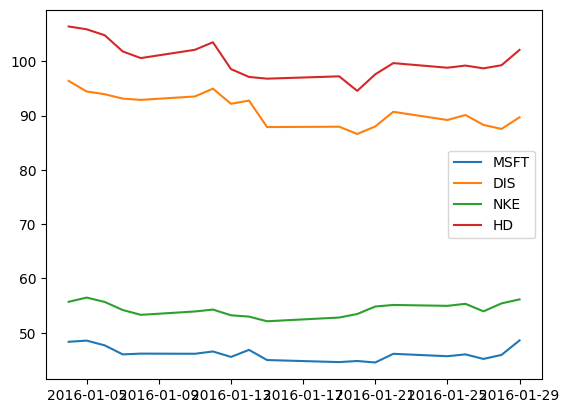

Problem name: Portfolio optimization

Minimize
  0.000296085895215993*x_0^2 + 0.000364874789848017*x_0*x_1
  + 0.00023002808583030495*x_0*x_2 + 0.0002563403096882184*x_0*x_3
  + 0.00020867502646084644*x_1^2 + 0.0001642390631580077*x_1*x_2
  + 0.00027057317853094873*x_1*x_3 + 0.0001418017408659883*x_2^2
  + 0.00022027874459325003*x_2*x_3 + 0.00021053180106028125*x_3^2
  - 0.0005706276903724902*x_0 + 0.0037964338413801323*x_1
  - 0.000574933647029109*x_2 + 0.0020947885119193604*x_3

Subject to
  Linear constraints (1)
    x_0 + x_1 + x_2 + x_3 == 2  'c0'

  Binary variables (4)
    x_0 x_1 x_2 x_3



In [6]:
qp, data = realdata_to_qp()

# Visualize the data
for cnt, s in enumerate(data._tickers):
    plt.plot(data._data[cnt], label=s)
plt.legend()
plt.show()

# Print the quadratic program
print(qp.prettyprint())

## Ideal simulations

In [ ]:
# Plot statistics for all three winning models
statistics_count = 100
num_assets = 4
save_folder = r"D:/Qiskit hackathon/plots_winners/real_data_ideal_sim/"

# Data
qp, data = realdata_to_qp()

# Winning models, with the best parameters:
result_functions_dict = {
    get_result_SamplingVQE: [
        {
            "qp": qp,
            "ansatz": TwoLocal(num_qubits=num_assets,rotation_blocks='rx', reps=1, 
                               skip_final_rotation_layer=True),
            "optimizer": COBYLA(),
            "sampler": Sampler(),
            "penalty": None
        },
        {
            "qp": qp,
            "ansatz": TwoLocal(num_qubits=num_assets,rotation_blocks=["y", "rx"], reps=1, 
                               entanglement="full", entanglement_blocks="ecr"),
            "optimizer": COBYLA(),
            "sampler": Sampler(),
            "penalty": None
        }
    ],
    get_result_QAOA: [
        {
            "qp": qp,
            "optimizer": COBYLA(),
            "reps": 2
        }
    ]
}

# Exact result via classical eigensolver
result_exact = get_result_numpy(qp)
reference_cost = result_exact.min_eigen_solver_result.eigenvalue.real
reference_fval = result_exact.fval

# Initialize a dictionary to store the results
results = {}

# Statistics
for iteration in range(statistics_count):
    # Sweep through model dictionary
    for result_function, configs in result_functions_dict.items():
        for i, kwargs in enumerate(configs):
            print("Run ", iteration, " for ", result_function.__name__, " with config ", i)
            result, cost_history_dict = get_result_wrapper(result_function, **kwargs)
            if f"{result_function.__name__}_{i}" not in results:
                results[f"{result_function.__name__}_{i}"] = {}
            results[f"{result_function.__name__}_{i}"][iteration] = {
                "result": result,
                "cost_history_dict": cost_history_dict["cost"]
            }



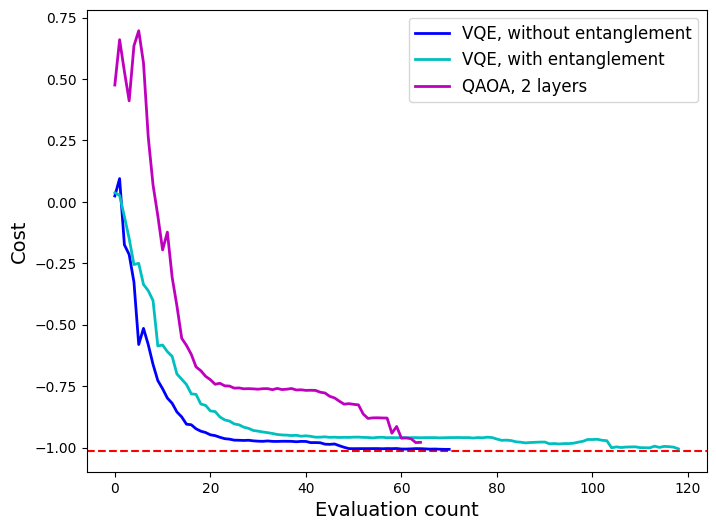

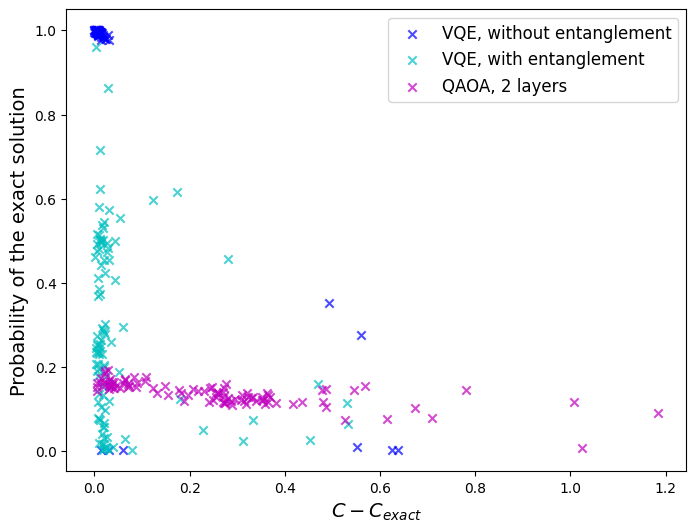

In [30]:
save_folder = r"D:/Qiskit hackathon/plots_winners/real_data_ideal_sim/"

# Assign labels to models
results['get_result_SamplingVQE_0']['label'] = "VQE, without entanglement"
results['get_result_SamplingVQE_1']['label'] = "VQE, with entanglement"
results['get_result_QAOA_0']['label'] = "QAOA, 2 layers"
results['get_result_SamplingVQE_0']['color'] = "b"
results['get_result_SamplingVQE_1']['color'] = "c"
results['get_result_QAOA_0']['color'] = "m"

# Plot mean value of cost function for all models
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.axhline(reference_cost, color="red", ls="--")
mean_cost={}
for key, value in results.items():
    # Compute the maximum length of the cost history
    max_len = 0
    for i in range(statistics_count):
        len_temp = len(results[key][i]['cost_history_dict'])
        if len_temp > max_len:
            max_len = len_temp

    # Pad the cost history with NaNs and stack the data
    stacked_data = np.full(max_len, np.nan)
    for i in range(statistics_count):
        completed_array = np.full(max_len, np.nan)
        completed_array[:len(results[key][i]['cost_history_dict'])] = results[key][i]['cost_history_dict']
        results[key][i]['cost_history_dict'] = completed_array
        stacked_data = np.vstack([stacked_data, results[key][i]['cost_history_dict']])

    mean_cost[key] = np.nanmean(stacked_data, axis=0)
    
    # Plot the mean value of the cost function
    ax.plot(mean_cost[key], lw=2, color=results[key]['color'], label=results[key]['label'])

# Complete the cost plot
ax.set_ylabel("Cost", fontsize=14)
ax.set_xlabel("Evaluation count", fontsize=14)
ax.legend(fontsize=12)
fig.savefig(save_folder + r"mean_cost.png")

# Plot the probability of the exact solution as a function of the error in the cost function value (compared to the exact solution)
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for key, value in results.items():
    error_vqe_cost = []
    prob_vqe_exact = []
    for i in range(statistics_count):
        error_vqe_cost.append(results[key][i]['result'].min_eigen_solver_result.eigenvalue.real - reference_cost)
        prob_vqe_exact.append(prob_exact(results[key][i]['result'], result_exact))
    ax.scatter(error_vqe_cost, prob_vqe_exact, marker="x", alpha=0.7,
               label=results[key]['label'], color=results[key]['color'])

# Complete the probability plot
ax.set_ylabel("Probability of the exact solution", fontsize=14)
ax.set_xlabel("$C - C_{exact}$", fontsize=14)
ax.legend(fontsize=12)
fig.savefig(save_folder + r"probabilities.png")

## Noisy simulations

In [7]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from scipy.optimize import minimize

In [ ]:
def get_result_runtime(
        qp,
        ansatz,
        token,
        optimization_level=2
):
    """
    Get the result using a noisy simulation.
    """

    # Set up backend simulator
    service = QiskitRuntimeService(
        channel='ibm_quantum',
        instance='ibm-q/open/main',
        token=token
    )
    backend = service.backend('ibm_sherbrooke')

    # generate a simulator that mimics the real quantum system with the latest calibration results
    backend_sim = AerSimulator.from_backend(backend)

    #Import estimator and specify that we are using the simulated backend:
    estimator = Estimator(mode=backend_sim)

    # Convert from QP to QUBO and then to Ising Hamiltonian
    conv = QuadraticProgramToQubo()
    qubo = conv.convert(qp)
    hamiltonian, offset = qubo.to_ising()

    # Transpile the ansatz and 
    target = backend.target
    pm = generate_preset_pass_manager(target=target, optimization_level=optimization_level)

    ansatz_isa = pm.run(ansatz)
    hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

    # Execute
    def cost_func(params, ansatz, hamiltonian, estimator):
        """Return estimate of energy from estimator

        Parameters:
            params (ndarray): Array of ansatz parameters
            ansatz (QuantumCircuit): Parameterized ansatz circuit
            hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
            estimator (EstimatorV2): Estimator primitive instance
            cost_history_dict: Dictionary for storing intermediate results

        Returns:
            float: Energy estimate
        """
        pub = (ansatz, [hamiltonian], [params])
        result = estimator.run(pubs=[pub]).result()
        energy = result[0].data.evs[0]

        cost_history_dict["params"].append(params)
        cost_history_dict["cost"].append(energy)
        print(f"Iters. done: {len(cost_history_dict['cost'])} [Current cost: {energy}]")

        return energy

    cost_history_dict = {
        "params": [],
        "cost": [],
        "meta": []
    }

    # Initial parameters
    x0 = 2 * np.pi * np.random.random(ansatz.num_parameters)
    
    # Run
    with Session(backend=backend_sim) as session:
        estimator = Estimator(mode=session)
        estimator.options.default_shots = 1000

        res = minimize(
            cost_func,
            x0,
            args=(ansatz_isa, hamiltonian_isa, estimator),
            method="cobyla",
        )
    
    return res, cost_history_dict

In [ ]:
# Plot statistics for all three winning models
statistics_count = 10
num_assets = 4
save_folder = r"D:/Qiskit hackathon/plots_winners/real_data_noisy_sim/"
optimization_level_sweep = [0, 1, 2, 3]

# Data
qp, data = realdata_to_qp()

# Winning models, with the best parameters:
ansatz = TwoLocal(num_qubits=num_assets,rotation_blocks='rx', reps=1, skip_final_rotation_layer=True)

# Exact result via classical eigensolver
result_exact = get_result_numpy(qp)
reference_cost = result_exact.min_eigen_solver_result.eigenvalue.real
reference_fval = result_exact.fval

# Initialize a dictionary to store the results
results = {}

# Statistics
for iteration in range(statistics_count):

    # One first run with the ideal simulator, labeled as optimization level 4
    print("Run ", iteration, " for ideal simulation")
    result, cost_history_dict = get_result_SamplingVQE(
        qp=qp,
        ansatz=ansatz,
        optimizer=COBYLA(),
        sampler=Sampler(),
        penalty=None
    )
    if "4" not in results:
        results["4"] = {}
    results["4"][iteration] = {
        "result": result,
        "cost_history_dict": cost_history_dict["cost"]
    }
    
    # Sweep through optimization levels
    for optimization_level in optimization_level_sweep:
        print("Run ", iteration, " for optimization level ", optimization_level)
        result, cost_history_dict = get_result_runtime(
            qp=qp,
            ansatz=ansatz,
            token='af161201d23e02f33b4da88e4525e6de0aa24575e3fda357e37520e78b7f5ff3180d61fd9ae38f530b533af75197f7b8e38d7af45a37b7b4efc0e93865fae128',
            optimization_level=optimization_level
        )
        if f"{optimization_level}" not in results:
            results[f"{optimization_level}"] = {}
        results[f"{optimization_level}"][iteration] = {
            "result": result,
            "cost_history_dict": cost_history_dict["cost"]
        }


Run  0  for ideal simulation
Run  0  for optimization level  0
Iters. done: 1 [Current cost: -0.14278843358130938]
Iters. done: 2 [Current cost: -0.1276913999918359]
Iters. done: 3 [Current cost: -0.4835470543642327]
Iters. done: 4 [Current cost: -0.5964917800944967]
Iters. done: 5 [Current cost: -0.14082636103898474]
Iters. done: 6 [Current cost: -0.7708481845876411]
Iters. done: 7 [Current cost: -0.9002509892738457]
Iters. done: 8 [Current cost: -0.759586302971299]
Iters. done: 9 [Current cost: -0.6415070199908384]
Iters. done: 10 [Current cost: -0.8307157607039735]
Iters. done: 11 [Current cost: -0.9114370974540502]
Iters. done: 12 [Current cost: -0.8872564471387419]
Iters. done: 13 [Current cost: -0.8861448172678641]
Iters. done: 14 [Current cost: -0.905363812004653]
Iters. done: 15 [Current cost: -0.8711021844931064]
Iters. done: 16 [Current cost: -0.9043548590653889]
Iters. done: 17 [Current cost: -0.8791910918450347]
Iters. done: 18 [Current cost: -0.9255556340737272]
Iters. don

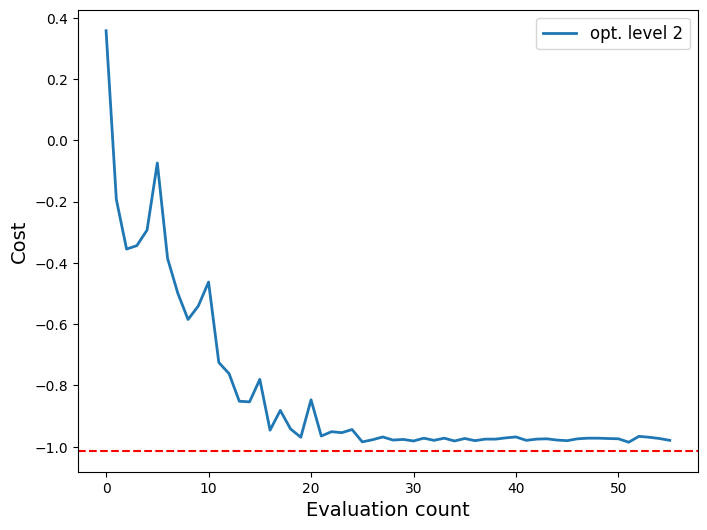

In [ ]:
save_folder = r"D:/Qiskit hackathon/plots_winners/real_data_noisy_sim/"


# Plot mean value of cost function for all models
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.axhline(reference_cost, color="red", ls="--")
mean_cost={}
for key, value in results.items():
    # Compute the maximum length of the cost history
    max_len = 0
    for i in range(statistics_count):
        len_temp = len(results[key][i]['cost_history_dict'])
        if len_temp > max_len:
            max_len = len_temp

    # Pad the cost history with NaNs and stack the data
    stacked_data = np.full(max_len, np.nan)
    for i in range(statistics_count):
        completed_array = np.full(max_len, np.nan)
        completed_array[:len(results[key][i]['cost_history_dict'])] = results[key][i]['cost_history_dict']
        results[key][i]['cost_history_dict'] = completed_array
        stacked_data = np.vstack([stacked_data, results[key][i]['cost_history_dict']])

    mean_cost[key] = np.nanmean(stacked_data, axis=0)
    
    # Plot the mean value of the cost function
    if key == '4':
        ax.plot(mean_cost[key], lw=2, color='k', label='ideal simulation')
    else:
        ax.plot(mean_cost[key], lw=2, label='noisy, opt. level ' + key)

# Complete the cost plot
ax.set_ylabel("Cost", fontsize=14)
ax.set_xlabel("Evaluation count", fontsize=14)
ax.legend(fontsize=12)
ax.set_title("VQE without entanglement", fontsize=14)
fig.savefig(save_folder + r"VQE_no_ent_mean_cost.png")

In [8]:
# Set up backend simulator
service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token='af161201d23e02f33b4da88e4525e6de0aa24575e3fda357e37520e78b7f5ff3180d61fd9ae38f530b533af75197f7b8e38d7af45a37b7b4efc0e93865fae128'
)
backend = service.backend('ibm_sherbrooke')

# generate a simulator that mimics the real quantum system with the latest calibration results
backend_sim = AerSimulator.from_backend(backend)

#Import estimator and specify that we are using the simulated backend:
estimator = Estimator(mode=backend_sim)

In [9]:
# Convert from QP to QUBO and then to Ising Hamiltonian
conv = QuadraticProgramToQubo()
qubo = conv.convert(qp)
hamiltonian, offset = qubo.to_ising()
print("offset: {}".format(offset))
print("operator:")
print(hamiltonian)

offset: 1.0125781736086155
operator:
SparsePauliOp(['IIIZ', 'IIZI', 'IZII', 'ZIII', 'IIZZ', 'IZIZ', 'ZIIZ', 'IZZI', 'ZIZI', 'ZZII'],
              coeffs=[-7.55398988e-05+0.j, -2.20247619e-03+0.j,  6.29294797e-05+0.j,
 -1.33945821e-03+0.j,  5.04791325e-01+0.j,  5.04757613e-01+0.j,
  5.04764191e-01+0.j,  5.04741166e-01+0.j,  5.04767749e-01+0.j,
  5.04755176e-01+0.j])


In [10]:
optimization_level = 2

# Choice of Ansatz
ansatz = EfficientSU2(hamiltonian.num_qubits)

# Transpile the ansatz
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=optimization_level)

ansatz_isa = pm.run(ansatz)
# ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")

hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

In [11]:
# Execute
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

# Initial parameters
x0 = 2 * np.pi * np.random.random(ansatz.num_parameters)


In [13]:
with Session(backend=backend_sim) as session:
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 1000

    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, hamiltonian_isa, estimator),
        method="cobyla",
    )

Iters. done: 1 [Current cost: -0.03934214175532605]
Iters. done: 2 [Current cost: 0.033763114185515836]
Iters. done: 3 [Current cost: -0.11213464989049943]
Iters. done: 4 [Current cost: -0.14699882970697326]
Iters. done: 5 [Current cost: -0.25309242204023763]
Iters. done: 6 [Current cost: -0.21593159718231447]
Iters. done: 7 [Current cost: -0.2278183245426092]
Iters. done: 8 [Current cost: -0.27086604050722596]
Iters. done: 9 [Current cost: -0.2863852834408021]
Iters. done: 10 [Current cost: -0.24340635269564093]
Iters. done: 11 [Current cost: -0.18232772128523128]
Iters. done: 12 [Current cost: -0.2964301429472645]
Iters. done: 13 [Current cost: -0.08077288209399712]
Iters. done: 14 [Current cost: -0.2728742520780141]
Iters. done: 15 [Current cost: -0.354667436656357]
Iters. done: 16 [Current cost: -0.32540979452907703]
Iters. done: 17 [Current cost: -0.2844871307082232]
Iters. done: 18 [Current cost: -0.2108823631796804]
Iters. done: 19 [Current cost: -0.2260719159120615]
Iters. done

KeyboardInterrupt: 

d:\Qiskit hackathon\.venv\Lib\site-packages\numpy\ma\core.py:3448: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval


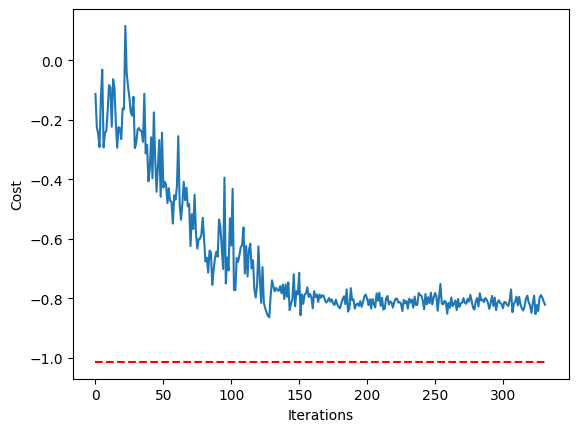

In [49]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.hlines(result_exact.min_eigen_solver_result.eigenvalue, 0, cost_history_dict["iters"], colors="r", linestyles="dashed")
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()